# Importing Libraries


In [7]:
!pip install scipy

In [2]:
from wfield import *
import matplotlib.pyplot as plt
import re
import os
import pandas as pd
import h5py
from scipy.ndimage import label
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator



# Defining functions

In [3]:
def extract_trial_data(bpod_data, states_list):
    trials = bpod_data['SessionData'][0, 0]['RawEvents']['Trial'][0, 0]

    # Lists to hold the data
    num_trials = []
    trial_types = []
    outcomes = []

    # Loop through each trial
    for trial in range(trials.shape[1]):
        trial_data = trials[0, trial]
        trial_type = bpod_data['SessionData'][0, 0]['TrialTypes'][0, trial]
        states = trial_data['States'][0, 0]  # Adjust according to your data structure
        outcome = None  # Initialize outcome as None

        # Determine the outcome based on the states
        for state in states_list:
            if not np.isnan(states[state][0, 0]).any():  # Check for valid state data
                if state == 'Hit':
                    outcome = 2
                elif state == 'Anticipatory_Hit':
                    outcome = 1
                elif state == 'Miss':
                    outcome = -1
                elif state == 'Anticipatory_Miss':
                    outcome = 0
                break  # Exit loop once a valid state is found

        if outcome is None:
            print("No valid state found for trial", trial + 1)

        # Append data to the lists
        num_trials.append(trial + 1)
        trial_types.append(trial_type)
        outcomes.append(outcome)

    return num_trials, trial_types, outcomes

# Example usage:
# bpod_data = <your_bpod_data>  # Replace with your actual data
# states_list = ['Hit', 'Anticipatory_Hit', 'Miss', 'Anticipatory_Miss']
# 


In [4]:
# def list_scans(data_folder, keyword):
#     # Find folders containing the keyword
#     scan_folders = [folder for folder in os.listdir(data_folder) if os.path.isdir(os.path.join(data_folder, folder)) and keyword in folder]

#     # Print list of found folders
#     print(f"Folders containing '{keyword}' keyword:")
#     for i, folder in enumerate(scan_folders):
#         print(f"{i + 1}. {folder}")

#     # Prompt user to choose a folder
#     while True:
#         choice = input("Enter the number of the scan you want to choose: ")
#         if choice.isdigit() and 1 <= int(choice) <= len(scan_folders):
#             chosen_folder = scan_folders[int(choice) - 1]
#             break
#         else:
#             print("Invalid input. Please enter a valid number.")
#     print("Selected",chosen_folder)
#     # Return the path to the chosen folder
#     return os.path.join(data_folder, chosen_folder), chosen_folder


In [5]:
# import os

def list_scans(data_folder, keyword):
    # Find folders containing the keyword and get their creation time
    scan_folders = [(folder, os.stat(os.path.join(data_folder, folder)).st_ctime) for folder in os.listdir(data_folder) 
                    if os.path.isdir(os.path.join(data_folder, folder)) and keyword in folder]

    # Sort folders by creation time, newest first
    scan_folders.sort(key=lambda x: x[1], reverse=True)

    # Extract folder names for display
    scan_folder_names = [folder[0] for folder in scan_folders]

    # Print list of found folders
    print(f"Folders containing '{keyword}' keyword:")
    for i, folder in enumerate(scan_folder_names):
        print(f"{i + 1}. {folder}")

    # Prompt user to choose a folder
    while True:
        choice = input("Enter the number of the scan you want to choose: ")
        if choice.isdigit() and 1 <= int(choice) <= len(scan_folder_names):
            chosen_folder = scan_folder_names[int(choice) - 1]
            break
        else:
            print("Invalid input. Please enter a valid number.")
    
    print(f"Selected")
    print(f"{int(choice)}. {chosen_folder}")

    # Return the path to the chosen folder
    return os.path.join(data_folder, chosen_folder), chosen_folder


In [6]:
def demultiplex(auxdata, channels=5):
    """Demultiplex the digital data"""
    auxdata = auxdata.flatten()
    binary = [[int(x) for x in f'{x:0{channels}b}'] for x in auxdata]
    return np.array(binary, dtype=bool).T

In [7]:
def find_event_sizes(signal):
    event_sizes = []
    event_positions = []
    trialON_idx = []
    rewards_idx = []
    event_start = None

    for i, val in enumerate(signal):
        if val == 1 and event_start is None:
            event_start = i
        elif val == 0 and event_start is not None:
            event_duration = i - event_start
            event_sizes.append(event_duration)
            if event_duration > 10:
                rewards_idx.append((event_start, i))
            else:
                trialON_idx.append((event_start, i))
            # event_positions.append((event_start, i))
            event_start = None

    if event_start is not None:  # Handle case where the last event goes till the end
        event_duration = len(signal) - event_start
        event_sizes.append(event_duration)
        event_positions.append((event_start, len(signal)))
    
    return event_sizes, trialON_idx,rewards_idx

In [8]:
def list_bpod(localdisk):
    import scipy.io
    mat_files = glob(pjoin(localdisk,'*.mat'))
    if len(mat_files) > 1:
        print("Multiple Bpod files found:")
        for i, mat_file in enumerate(mat_files):
            print(f"{i + 1}. {os.path.basename(mat_file)}")
        
        while True:
            choice = input("Enter the number of the .dat file you want to choose: ")
            if choice.isdigit() and 1 <= int(choice) <= len(mat_files):
                mat_path = mat_files[int(choice) - 1]
                break
            else:
                print("Invalid input. Please enter a valid number.")
    elif len(mat_files) == 1:
        mat_path = mat_files[0]
        print("Bpod file found")
        print("Loading...")
    else:
        print("Bpod file not found")
        print("-----------------------")
    
    try:
        bpod_data = scipy.io.loadmat(mat_path)
        print("Selected", os.path.basename(mat_path))
    except:
        print("Failed")
    return bpod_data


In [9]:
# Load the HDF5 file and read the necessary datasets
def load_h5_data(h5_path):
    with h5py.File(h5_path, 'r') as f:
        sweep_data_key = list(f.keys())[1]
        sweep_data = f[sweep_data_key]
        header = f['header']

        AIChannelNames = header['AIChannelNames'][:]
        DIChannelNames = header['DIChannelNames'][:]
        YLimitsPerAIChannel = header['YLimitsPerAIChannel'][:]
        AIChannelNames = [name.decode('utf-8') for name in AIChannelNames]
        DIChannelNames = [name.decode('utf-8') for name in DIChannelNames]
        SampleRate = header['AcquisitionSampleRate'][:]

        analogData = sweep_data['analogScans'][:]
        digitalData = sweep_data['digitalScans'][:]

        return AIChannelNames, DIChannelNames, SampleRate[0, 0], analogData, digitalData

# Convert analogData and digitalData to DataFrame
def create_dataframe(ai_channel_names, di_channel_names, sample_rate, analog_data, digital_data):
    # Create DataFrame for analog data
    df_analog = pd.DataFrame(analog_data.T, columns=ai_channel_names)

    # Create DataFrame for digital data
    df_digital = pd.DataFrame(digital_data.T, columns=di_channel_names)

    # Concatenate analog and digital data
    df = pd.concat([df_analog, df_digital], axis=1)

    # Add time column
    df['time_seconds'] = df.index / sample_rate

    return df

In [10]:
def extract_trials(data, idx_list, pre_window, post_window):
    trials = []
    for start, end in idx_list:
        trial_start = max(0, start - pre_window)
        trial_end = min(len(data), end + post_window)
        trial_data = data[trial_start:trial_end]
        trials.append(trial_data)
    return trials

In [11]:
def calculate_scaled_cumulative_percentages(df, outcome_col, task_col, mouse_col, trial_col, date_col, outcome_map):
    # Group by mouse and task
    grouped = df.groupby([mouse_col, task_col])
    
    plot_data = []
    
    # Loop through each group (mouse-task pair)
    for (mouse, task), group in grouped:
        # Sort by Date to ensure chronological order
        group = group.sort_values(by=[date_col, trial_col])
        
        # Calculate final percentage for each outcome type at the last trial
        total_trials = len(group)
        final_outcome_counts = group[outcome_col].value_counts(normalize=True).to_dict()
        
        # Normalize final outcome counts to percentages
        final_percentages = {outcome_map.get(key, key): final_outcome_counts.get(key, 0) * 100 for key in outcome_map}
        
        # Initialize cumulative counters
        cumulative_counts = {outcome: 0 for outcome in outcome_map.values()}
        cumulative_scaled_percentages = {outcome: [] for outcome in outcome_map.values()}
        
        # Initialize lists to store the trial numbers and gaps in days for new training days
        new_day_trials = []
        day_gaps = []
        last_date = None

        # Loop through trials and calculate cumulative scaled percentage
        for index, row in group.iterrows():
            outcome = outcome_map[row[outcome_col]]
            cumulative_counts[outcome] += 1
            
            # Check if a new training day has started
            current_date = row[date_col]
            if last_date is not None and current_date != last_date:
                # Store the trial number of the new day
                new_day_trials.append(row[trial_col])
                
                # Calculate the gap in days if the days are not consecutive
                date_diff = (current_date - last_date).days
                if date_diff > 1:
                    day_gaps.append((row[trial_col], date_diff))  # Store the gap as (trial number, gap in days)
                
            # Update last date
            last_date = current_date
            
            # Calculate scaled cumulative percentages based on the final percentage
            for outcome_key in cumulative_scaled_percentages:
                final_percentage = final_percentages[outcome_key]
                scaled_percentage = (cumulative_counts[outcome_key] / total_trials) * 100
                cumulative_scaled_percentages[outcome_key].append(scaled_percentage)
        
        # Append data for plotting
        plot_data.append({
            'mouse': mouse,
            'task': task,
            'num_trials': group[trial_col],
            'percentages': cumulative_scaled_percentages,
            'final_percentages': final_percentages,
            'new_day_trials': new_day_trials,  # Store the trial numbers of new training days
            'day_gaps': day_gaps  # Store gaps as (trial number, gap in days)
        })
    
    return plot_data




In [12]:
def decode_base36_timestamp(base36_string, exp=6):
    import datetime

    # Convert the Base-36 string back to an integer
    decimal_value = int(base36_string, 36)
    
    # Convert the decimal value back to a time serial by dividing by 10^exp
    time_serial = decimal_value / (10 ** exp)
    
    # Convert the time serial to a Python datetime object
    date_value = datetime.datetime.fromordinal(int(time_serial)) + \
                 datetime.timedelta(days=time_serial % 1) - \
                 datetime.timedelta(days=366)  # MATLAB 'now()' is offset by 366 days

    # Format the datetime object as 'YYYY-MM-DD HH:MM:SS'
    formatted_date = pd.to_datetime(date_value).floor('s')  # Trim microseconds

    return formatted_date

# Reading Aux file

In [13]:
data_folder = r'/datajoint-data/data/aeltona/'
localdisk, scan_idx = list_scans(data_folder,"AA_ROS-1940")

Folders containing 'AA_ROS-1940' keyword:
1. AA_ROS-1940_2024-11-23_scan_sess
2. AA_ROS-1940_2024-11-22_scan9FRA1OGG_sess9FRA1OGG
3. AA_ROS-1940_2024-11-21_scan9FR9GXZK_sess9FR9GXZK
4. AA_ROS-1940_2024-11-21_scan9FR9H9HG_sess9FR9H9HG
5. AA_ROS-1940_2024-10-17_scan9FQONLVX_sess9FQONLVX
6. AA_ROS-1940_2024-11-19_scan9FR8AQDA_sess9FR8AQDA
7. AA_ROS-1940_2024-11-20_scan9FR8W5K8_sess9FR8W5K8
8. AA_ROS-1940_2024-10-22_scan9FQRLN5V_sess9FQRLN5V
9. AA_ROS-1940_2024-11-12_scan9FR45QQL_sess9FR45QQL
10. AA_ROS-1940_2024-11-13_scan9FR4QZ20_sess9FR4QZ20
11. AA_ROS-1940_2024-11-14_scan9FR5BBKG_sess9FR5BBKG
12. AA_ROS-1940_2024-11-15_scan9FR5WEI0_sess9FR5WEI0
13. AA_ROS-1940_2024-10-31_scan9FQWZPJT_sess9FQWZPJT
14. AA_ROS-1940_2024-10-30_scan9FQWF6WI_sess9FQWF6WI
15. AA_ROS-1940_2024-10-28_scan9FQV7UMA_sess9FQV7UMA
16. AA_ROS-1940_2024-10-29_scan9FQVSWJ1_sess9FQVSWJ1


Enter the number of the scan you want to choose:  2


Selected
2. AA_ROS-1940_2024-11-22_scan9FRA1OGG_sess9FRA1OGG


In [16]:
h5_path = glob(pjoin(localdisk,'*.h5'))[0]
h5_path

'/datajoint-data/data/aeltona/AA_ROS-1940_2024-11-22_scan9FRA1OGG_sess9FRA1OGG/AA_ROS-1940_2025.h5'

In [17]:

# Open the HDF5 file
with h5py.File(h5_path, 'r') as f:
    sweep_data_key = list(f.keys())[1]
    # print(sweep_data_key)
    sweep_data = f[sweep_data_key]
    # print(sweep_data.keys())
    header = f['header'] 
    # print(header.keys())    
    AIChannelNames = header['AIChannelNames'][:]
    DIChannelNames = header['DIChannelNames']
    DIChannelTerminalIDs = header['DIChannelTerminalIDs'][:]
    YLimitsPerAIChannel = header['YLimitsPerAIChannel'][:]
    AIChannelNames = [name.decode('utf-8') for name in AIChannelNames]
    DIChannelNames = [name.decode('utf-8') for name in DIChannelNames]
    SampleRate = header['AcquisitionSampleRate'][:]
    analogData = sweep_data['analogScans'][:]
    digitalData = sweep_data['digitalScans'][:]

In [18]:
DIChannelNames

['Main Trigger',
 'Bench2p 920 shutter',
 'Frame clock',
 'Line clock',
 'Volume clock',
 'VisStim_ON']

In [19]:
sampling_rate_hz = int(SampleRate[0,0])
sampling_rate_hz

20000

In [20]:
# Convert analogData to DataFrame
df = pd.DataFrame(analogData.T, columns=AIChannelNames)
sampling_rate_hz = int(SampleRate[0,0])
df['time_seconds'] = df.index / sampling_rate_hz
# Print DataFrame
# print(df)
df.columns

Index(['TrialTypeON', 'Rotary Encoder', 'Camera Trigger', 'FakeReward',
       'Reward', 'Licks', 'HIFI', 'time_seconds'],
      dtype='object')

In [21]:
df.shape

(48044690, 8)

## Digital channels

In [ ]:
digital_scans = demultiplex(digitalData[0], len(DIChannelNames))


In [ ]:
reversed_DIChannelNames = DIChannelNames[::-1]
digital_scans_T = digital_scans.T

digital_scans_df = pd.DataFrame(digital_scans_T, columns=reversed_DIChannelNames)
# df = pd.concat([df, digital_scans_df], axis=1)
# plt.plot(digital_scans_df['VisStim_ON']);
# plt.plot(df['HIFI']);

In [152]:
n = 1000  # Set the step size for sampling (grab every 1000th point)

# Downsample using list comprehension
visstim_on_sampled = digital_scans_df['VisStim_ON'][::n].reset_index(drop=True)
seconds_sampled = df['time_seconds'][::n].reset_index(drop=True)
hifi_sampled = df['HIFI'][::n].reset_index(drop=True)

# rewards = df['Reward'][::n]
fake_rewards = df['FakeReward'][::n]

licks = df['Licks'][::n]
# print(visstim_on_sampled.shape)

# Plot the downsampled data
# plt.plot(visstim_on_sampled, label='VisStim_ON',alpha=0.1, color ='red')
# plt.plot(hifi_sampled, label='HIFI', alpha=.1, color='black')
# plt.legend()
# plt.show()

In [153]:
# plt.plot((hifi_sampled >1000).astype(int))
# plt.show()
# plt.plot(visstim_on_sampled, color = 'red') 
# plt.show()

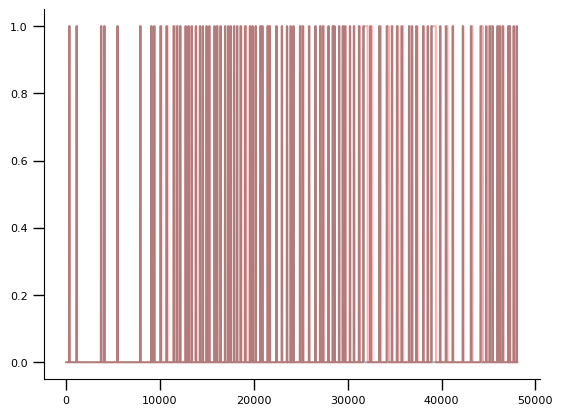

In [154]:
inicio, fim = 0, -1
plt.plot(visstim_on_sampled.iloc[inicio:fim], label='VisStim_ON',alpha=.3, color ='red')
plt.plot((hifi_sampled >1000).astype(int).iloc[inicio:fim], label='HIFI', alpha=.3, color='black')

In [155]:
# # Initialize lists to store results
# stim_order = []
# stim_start_idx = []
# stim_end_idx = []
# stim_durations = []

# # Variables to track whether we are inside a stimulus
# in_stimulus = False
# stim_count = 0

# # Loop over the indices and values in the visstim_on_sampled DataFrame
# for idx, val in visstim_on_sampled.items():
#     if val and not in_stimulus:
#         # Stimulus started
#         stim_start_idx.append(idx)
#         stim_count += 1
#         stim_order.append(stim_count)
#         in_stimulus = True
#     elif not val and in_stimulus:
#         # Stimulus ended
#         stim_end_idx.append(idx - 1)
#         in_stimulus = False

# # Add the last stimulus end if it ends at the end of the data
# if in_stimulus:
#     stim_end_idx.append(len(visstim_on_sampled) - 1)

# # Calculate the durations based on the seconds_sampled DataFrame
# for start_idx, end_idx in zip(stim_start_idx, stim_end_idx):
#     duration = seconds_sampled.loc[end_idx] - seconds_sampled.loc[start_idx]
#     stim_durations.append(duration)

# # Create the final DataFrame
# visstim_df = pd.DataFrame({
#     'stim_order': stim_order,
#     'start_idx': stim_start_idx,
#     'end_idx': stim_end_idx,
#     'duration_seconds': stim_durations
# })

# display(visstim_df)

In [156]:
# Initialize lists to store results
stim_order = []
stim_start_idx = []
stim_end_idx = []
stim_durations = []

# Variables to track whether we are inside a stimulus
in_stimulus = False
stim_count = 0

# Loop over the indices and values in the visstim_on_sampled DataFrame
for idx, val in digital_scans_df['VisStim_ON'].items():
    if val and not in_stimulus:
        # Stimulus started
        stim_start_idx.append(idx)
        stim_count += 1
        stim_order.append(stim_count)
        in_stimulus = True
    elif not val and in_stimulus:
        # Stimulus ended
        stim_end_idx.append(idx - 1)
        in_stimulus = False

# Add the last stimulus end if it ends at the end of the data
if in_stimulus:
    stim_end_idx.append(len(visstim_on_sampled) - 1)

# Calculate the durations based on the seconds_sampled DataFrame
for start_idx, end_idx in zip(stim_start_idx, stim_end_idx):
    duration = df['time_seconds'].loc[end_idx] - df['time_seconds'].loc[start_idx]
    stim_durations.append(duration)

# Create the final DataFrame
visstim_df = pd.DataFrame({
    'stim_order': stim_order,
    'start_idx': stim_start_idx,
    'end_idx': stim_end_idx,
    'duration_seconds': stim_durations
})

display(visstim_df)

stim_order  start_idx   end_idx  duration_seconds
0            1     282858    369113           4.31275
1            2    1067521   1139345           3.59120
2            3    3682029   3749773           3.38720
3            4    4027561   4083044           2.77415
4            5    5428141   5491715           3.17870
..         ...        ...       ...               ...
82          83   46499871  46602675           5.14020
83          84   47094587  47135288           2.03505
84          85   47251323  47296949           2.28130
85          86   47659378  47704089           2.23555
86          87   47980389  48022941           2.12760

[87 rows x 4 columns]

In [132]:
print(visstim_df['duration_seconds'].mean())
print(visstim_df['duration_seconds'].max())
print(visstim_df['duration_seconds'].min())



2.827740740740745
24.740999999999985
1.451300000000174


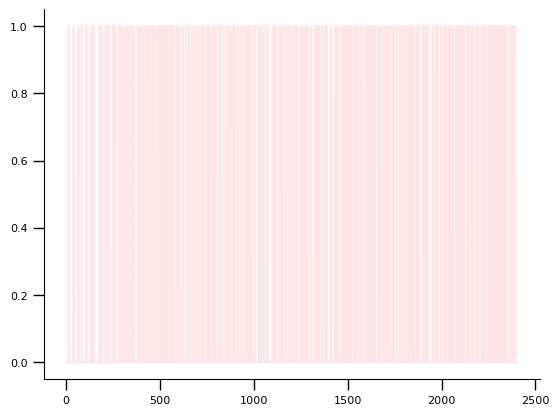

In [29]:
plt.plot(df['time_seconds'][::n],visstim_on_sampled, label='VisStim_ON',alpha=0.1, color ='red');
# plt.plot(hifi_sampled, label='HIFI', alpha=.1, color='black')   

In [52]:
def normalize_analog_data(data, threshold_factor=3):
    # Calculate the absolute differences between consecutive points
    diffs = np.abs(np.diff(data))

    # Determine a dynamic threshold (for example, using mean + N * standard deviation)
    threshold = np.mean(diffs) + threshold_factor * np.std(diffs)

    # Normalize the data based on the threshold
    normalized_data = np.where(diffs > threshold, 1, 0)

    return normalized_data

In [53]:
# normalized_hifi = normalize_analog_data(hifi_sampled)

# # Create subplots with two rows and one column
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), constrained_layout=True)  # Adjust figsize as needed

# # Plot the normalized HIFI data on the first subplot
# ax1.plot(normalized_hifi, label='HIFI Normalized', alpha=1)
# ax1.set_axis_off()  # Turn off axis for this subplot

# # Plot the VisStim_ON sampled data on the second subplot
# ax2.plot(visstim_on_sampled, label='VisStim_ON', alpha=1, color='red')
# ax2.set_axis_off()  # Turn off axis for this subplot

# # You can adjust the aspect ratio of each plot if needed
# ax1.set_aspect('auto')
# ax2.set_aspect('auto')

# # Show the plot
# plt.show()

# # To count the number of 'big differences' (i.e., transitions to 1)
# num_big_differences_hifi = np.sum(normalized_hifi)
# print(f"Number of big differences in HIFI: {num_big_differences_hifi}")


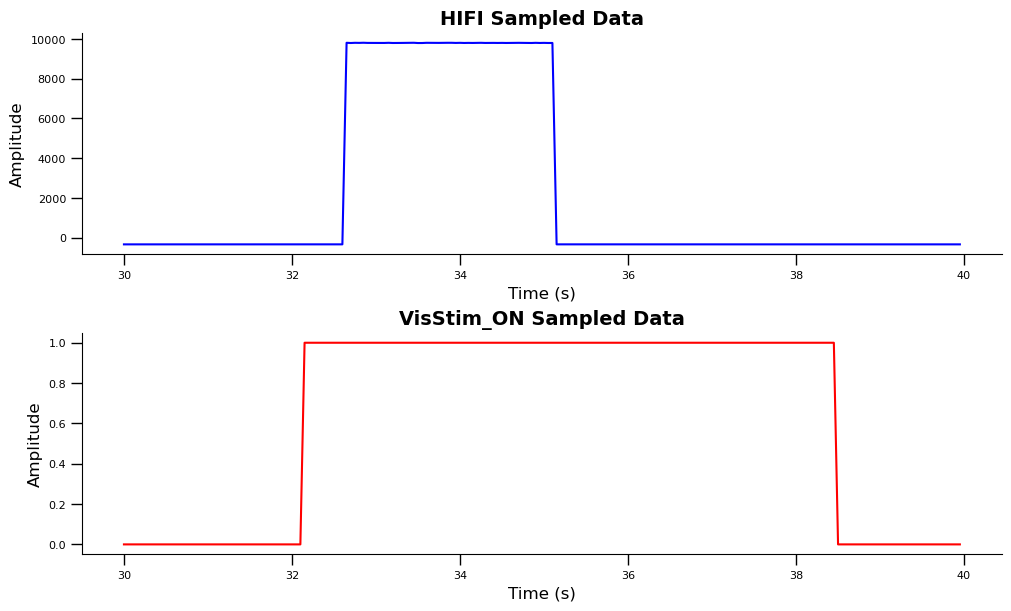

In [462]:

start, end = 600, 800  # Plot range

# Calculate time per sample after downsampling
sample_time_s = 1 / (sampling_rate_hz / n)

# Create a time array that matches the length of hifi_sampled
time_array = np.arange(len(hifi_sampled)) * sample_time_s  # Time in seconds

# Create subplots with two rows and one column
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), constrained_layout=True)
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# Plot the HIFI data with time axis
ax1.plot(time_array[start:end], hifi_sampled[start:end], color='blue')
ax1.set_title("HIFI Sampled Data")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Amplitude")

# Plot the VisStim_ON data with time axis
ax2.plot(time_array[start:end], visstim_on_sampled[start:end], color='red')
ax2.set_title("VisStim_ON Sampled Data")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Amplitude")


fig.patch.set_facecolor('white')
plt.savefig(r'/home/aeltona/wfield/notebooks/TAC figs/hifi_visstim.pdf')
# Show the plot
plt.show()




In [62]:
hifi_sampled.shape[0]

32862

In [68]:
start, end = 0, 100/sample_time_s #hifi_sampled.shape[0]-1  # Plot range
print(start,end)

0 2000.0


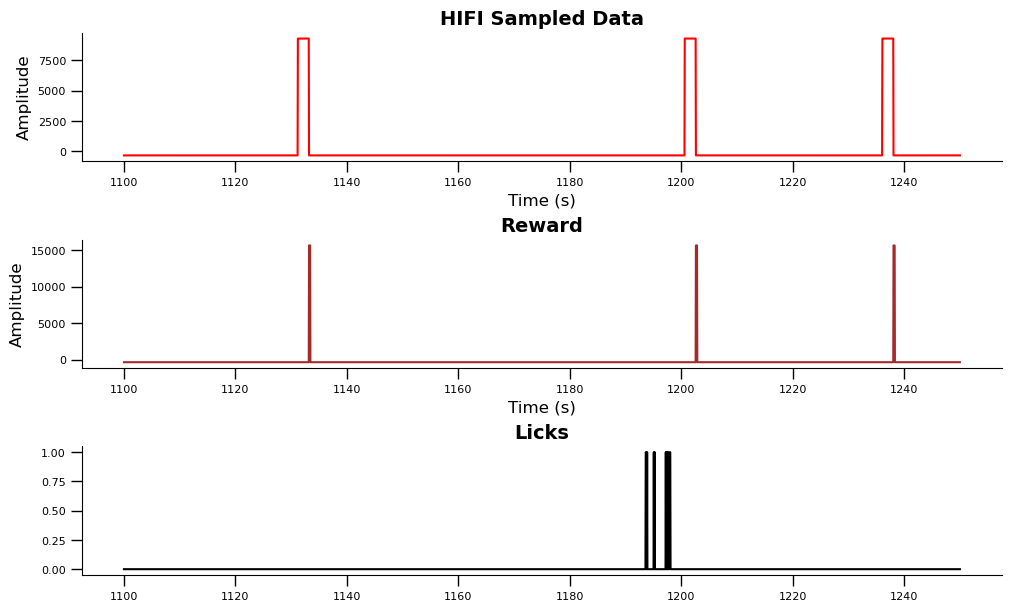

In [75]:

sample_time_s = 1 / (sampling_rate_hz / n)
start, end = int(1100/sample_time_s), int(1250/sample_time_s) #hifi_sampled.shape[0]-1  # Plot range
# start, end = 0, hifi_sampled.shape[0]-1  # Plot range

# Calculate time per sample after downsampling

# Create a time array that matches the length of hifi_sampled
time_array = np.arange(len(hifi_sampled)) * sample_time_s  # Time in seconds

# Create subplots with two rows and one column
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 6), constrained_layout=True)
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# Plot the HIFI data with time axis
ax1.plot(time_array[start:end], hifi_sampled[start:end], color='red')
ax1.set_title("HIFI Sampled Data")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Amplitude")

# Plot the VisStim_ON data with time axis
ax2.plot(time_array[start:end], fake_rewards[start:end], color='brown')
ax2.set_title("Reward")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Amplitude")

ax3.plot(time_array[start:end], normalize_analog_data(licks)[start:end], color='black')
ax3.set_title("Licks")


fig.patch.set_facecolor('white')
# plt.savefig(r'/home/aeltona/wfield/notebooks/TAC figs/hifi_licks_rewards.pdf')
# Show the plot
plt.show()




In [430]:
# Calculate sample time after downsampling
sample_time_s = 1 / (sampling_rate_hz / n)

# Calculate event durations for both hifi and visstim signals
hifi_durations = calculate_event_durations(normalized_hifi, sample_time_s)
visstim_durations = calculate_event_durations(visstim_on_sampled, sample_time_s)

# Calculate the mean duration of events for hifi and visstim
mean_hifi_duration = np.mean(hifi_durations)
mean_visstim_duration = np.mean(visstim_durations)

print(f"Mean HIFI Event Duration: {mean_hifi_duration:.4f} seconds")
print(f"Mean VisStim_ON Event Duration: {mean_visstim_duration:.4f} seconds")

Mean HIFI Event Duration: 0.0500 seconds
Mean VisStim_ON Event Duration: 1414.8922 seconds


In [34]:
df[DIChannelNames[0]] = digital_scans[1]
df[DIChannelNames[1]] = digital_scans[0]

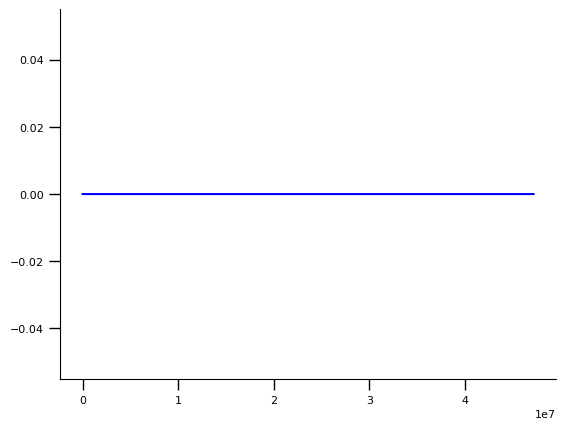

In [33]:
# df['HIFI_norm']= df["HIFI"] / df["HIFI"].max()

# plt.plot(digital_scans[0],c="blue");
# plt.plot(digital_scans[1],c='red');
# plt.plot(df['HIFI_norm'],c='black');
# plt.plot(digital_scans[1]);

## Licks

In [16]:
norm_TrialON_FRew = (df['TrialON_FRew'] - df['TrialON_FRew'].min()) / (df['TrialON_FRew'].max() - df['TrialON_FRew'].min())
norm_TrialON_FRew = norm_TrialON_FRew.round(0)
norm_Rew_StimON = (df['Reward'] - df['Reward'].min()) / (df['Reward'].max() - df['Reward'].min())
norm_Rew_StimON = norm_Rew_StimON.round(0)
norm_licks = (df['Lick Count'] - df['Lick Count'].min()) / (df['Lick Count'].max() - df['Lick Count'].min())
norm_licks = norm_licks.round(0)

In [35]:

try:
    norm_TrialON_FRew = (df['TrialON_FRew'] - df['TrialON_FRew'].min()) / (df['TrialON_FRew'].max() - df['TrialON_FRew'].min())
    norm_TrialON_FRew = norm_TrialON_FRew.round(0)
    norm_Rew_StimON = (df['Rew_StimON'] - df['Rew_StimON'].min()) / (df['Rew_StimON'].max() - df['Rew_StimON'].min())
    norm_Rew_StimON = norm_Rew_StimON.round(0)
    norm_licks = (df['Lick Count'] - df['Lick Count'].min()) / (df['Lick Count'].max() - df['Lick Count'].min())
    norm_licks = norm_licks.round(0)
except:
    # norm_TrialON_FRew = (df['FakeReward'] - df['FakeReward'].min()) / (df['FakeReward'].max() - df['FakeReward'].min())
    # try:
        norm_TrialON_FRew = df['FakeReward']
        norm_licks = (df['Licks'] - df['Licks'].min()) / (df['Licks'].max() - df['Licks'].min())
        norm_licks = norm_licks.round(0)
    # except:
        norm_Rew_StimON = (df['Reward'] - df['Reward'].min()) / (df['Reward'].max() - df['Reward'].min())
        norm_Rew_StimON = norm_Rew_StimON.round(0)
        


In [36]:
event_sizes, trialON_idx, rews_idx  = find_event_sizes(norm_Rew_StimON)

print("Event sizes:", np.unique(event_sizes))
print("Length of trialON_idx:", len(trialON_idx))
print("Length of rews_idx:", len(rews_idx))

Event sizes: [5250]
Length of trialON_idx: 0
Length of rews_idx: 20


In [37]:
event_sizes, trialON_idx, frews_idx  = find_event_sizes(norm_TrialON_FRew)

print("Event sizes:", np.unique(event_sizes))
print("Length of trialON_idx:", len(trialON_idx))
print("Length of frews_idx:", len(frews_idx))

Event sizes: [5250 5251]
Length of trialON_idx: 0
Length of frews_idx: 85


In [38]:
# Create arrays for trial onsets and rewards
trial_onsets = np.zeros_like(norm_TrialON_FRew)
frews = np.zeros_like(norm_TrialON_FRew)
rews = np.zeros_like(norm_Rew_StimON)

for start, end in trialON_idx:
    trial_onsets[start:end] = 1

for start, end in frews_idx:
    frews[start:end] = 1

for start, end in rews_idx:
    rews[start:end] = 1

In [39]:
pre_window = int(5 * sampling_rate_hz)  # 5 seconds before
post_window = int(10 * sampling_rate_hz)  # 10 seconds after

frews_trials = extract_trials(norm_licks, frews_idx, pre_window, post_window)
rews_trials = extract_trials(norm_licks, rews_idx, pre_window, post_window)


In [40]:
filename_parts = re.split(r'_|\.', scan_idx)
scan_info = '_'.join(filename_parts[0:5])
scan_info

'Habituation_AA_ROS-1792_2024-06-04_scan9FOG9RQH'

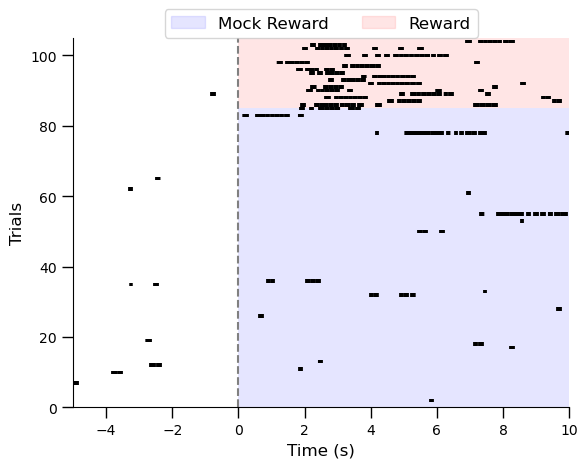

In [42]:
# Constants for time adjustment
pre_time_seconds = 5  # 5 seconds before the onset
post_time_seconds = 10  # 10 seconds after the onset

# Convert these times to index offsets
pre_index = pre_time_seconds * sampling_rate_hz
post_index = post_time_seconds * sampling_rate_hz

# Calculate total number of points to display
total_points = pre_index + post_index

# Adjust pre_window and post_window according to the onset index and total points
pre_window = 100000 - pre_index  # Adjusted to start 5s before the onset
post_window = 100000 + post_index  # Adjusted to end 10s after the onset

# Time conversion for x-axis (from indices to seconds, centered at onset)
time_axis = np.linspace(-pre_time_seconds, post_time_seconds, total_points)

# Adjust event plotting to reflect new time_axis
for i, trial in enumerate(frews_trials):
    events = np.where(trial)[0]
    valid_events = events[(events >= pre_window) & (events < post_window)] - 100000
    plt.eventplot(time_axis[valid_events + pre_index], lineoffsets=i, colors='black')

offset = len(frews_trials)
for i, trial in enumerate(rews_trials):
    events = np.where(trial)[0]
    valid_events = events[(events >= pre_window) & (events < post_window)] - 100000
    plt.eventplot(time_axis[valid_events + pre_index], lineoffsets=i + offset, colors='black')


num_frews_trials = len(frews_trials)
num_rews_trials = len(rews_trials)
total_trials = num_frews_trials + num_rews_trials

# Shading for frews_trials
for i in range(num_frews_trials):
    ymin = i / total_trials  # Adjust ymin based on total trials count
    ymax = (i + 1) / total_trials  # Adjust ymax similarly
    plt.axvspan(0, 10, facecolor='blue', alpha=0.1, ymin=ymin, ymax=ymax)

# Shading for rews_trials
for i in range(num_rews_trials):
    ymin = (i + num_frews_trials) / total_trials  # Start from the end of frews_trials
    ymax = (i + 1 + num_frews_trials) / total_trials
    plt.axvspan(0, 10, facecolor='red', alpha=0.1, ymin=ymin, ymax=ymax)

mock_reward_patch = patches.Patch(color='blue', alpha=0.1, label='Mock Reward')
reward_patch = patches.Patch(color='red', alpha=0.1, label='Reward')

# Update formatting
plt.xlabel('Time (s)')
plt.ylabel('Trials')
# plt.title('Raster Plot of Lick Events')
plt.axvline(0, color='grey', linestyle='--')  # Indicate the stimulus onset
plt.xlim([-5, 10])  # Set x-axis limits to -5s to 10s
plt.ylim(0,total_trials)

# Adjust tick label size
plt.xticks(fontsize=10)  # Adjust tick font size as needed
plt.yticks(fontsize=10)  # Adjust tick font size as needed

plt.legend(handles=[mock_reward_patch, reward_patch], loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)

# Construct the path to the folder where the plot will be saved
folder_path = os.path.join('/datajoint-data/data/aeltona', 'Licks')
file_path = os.path.join(folder_path, f'{scan_info}_licks')

# Check if the folder exists, and create it if it does not
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
# Save and show plot (make sure 'folder_path' and 'file_path' are correctly defined)
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
plt.savefig(f'{file_path}.svg')
plt.savefig(f'{file_path}.png')
plt.show()

In [ ]:
df['trial_onsets'] = trial_onsets
df['norm_licks'] = norm_licks
df['rews'] = rews
df['frews'] = frews
df.columns

Index(['camera_trigger', 'blue_470nm', 'violet_405nm', 'HIFI', 'Rew_StimON',
       'TrialON_FRew', 'Lick Count', 'Rotary Encoder', 'time_seconds',
       'trial_onsets', 'norm_licks', 'rews', 'frews'],
      dtype='object')

# Reading Bpod Data


In [31]:
data_folder = r'/datajoint-data/data/aeltona/'
localdisk, scan_idx = list_scans(data_folder,"AA_ROS-1792")

Folders containing 'AA_ROS-1792' keyword:
1. AudPassProbe_AA_ROS-1792_2024-06-15_scan9FOMVAUF_sess9FOMVAUF
2. AudPassCond_AA_ROS-1792_2024-06-15_scan9FOMVTU6_sess9FOMVAUF
3. AtivConditioning_AA_ROS-1792_2024-06-14_scan9FOM3HZ3_sess9FOM3HZ3
4. PassConditioning_AA_ROS-1792_2024-06-11_scan9FOKEEYA_sess9FOKEEYA
5. PassConditioning_AA_ROS-1792_2024-06-13_scan9FOLLVZB_sess9FOLLVZB
6. AtivConditioning_AA_ROS-1792_2024-06-13_scan9FOLMDEP_sess9FOLLVZB
7. AtivConditioning_AA_ROS-1792_2024-06-11_scan9FOKELLL_sess9FOKEEYA
8. PassConditioning_AA_ROS-1792_2024-06-11_scan9FOKEWPU_sess9FOKEEYA
9. PassConditioning_AA_ROS-1792_2024-06-12_scan9FOKYJK6_sess9FOKYJK6
10. Habituation_AA_ROS-1792_2024-05-28_scan9FOC2ZC0_sess9FOC2ZC0
11. PassConditioning_AA_ROS-1792_2024-06-10_scan9FOJUE5S_sess9FOJUE5S
12. PassConditioning_AA_ROS-1792_2024-06-10_scan9FOJVAWJ_sess9FOJUE5S
13. Preconditioning_AA_ROS-1792_2024-06-08_scan9FOIQ9VQ_sess9FOIQ9VQ
14. Preconditioning_AA_ROS-1792_2024-06-07_scan9FOI1FRY_sess9FOI1FRY
15.

In [32]:
bpod_data = list_bpod(localdisk)

Bpod file found
Loading...
Selected scan9FOMVAUF_AudPassProbe_ROS-1792_SensoryPreconditioning_20240615_190148.mat


In [33]:
two_sessions = False


# Outcome plot

In [34]:
# bpod_data['SessionData'][0, 0]['RawEvents']['Trial'][0, 0][0, 0]['States'][0, 0].dtype

In [79]:
states_list = ['Hit', 'Anticipatory_Hit','Miss','Anticipatory_Miss']
# states_list = ['Hit', 'Miss']
# states_list = ['Ignored_Hit', 'Anticipatory_Hit','Missed_Reward','Anticipatory_Miss']

num_trials, trial_types, outcomes = extract_trial_data(bpod_data, states_list)


In [80]:
# Create the DataFrame
outcome_df = pd.DataFrame({
    'num_trial': num_trials,
    'trial_type': trial_types,
    'outcome': outcomes
})

display(outcome_df[-5:])
first_session = outcome_df

num_trial  trial_type  outcome
30         31           2       -1
31         32           1        2
32         33           2       -1
33         34           2       -1
34         35           1        2

In [81]:
if two_sessions:
    print("Choose SECOND bpod session")
    bpod_data = list_bpod(localdisk)
    # states_list = ['Hit', 'Anticipatory_Hit','Miss','Anticipatory_Miss']
    num_trials, trial_types, outcomes = extract_trial_data(bpod_data, states_list)
    last_trial = first_session['num_trial'].max()
    # Create the DataFrame
    second_session = pd.DataFrame({
        'num_trial': [trial+last_trial for trial in num_trials],
        'trial_type': trial_types,
        'outcome': outcomes
    })

    display(second_session[-5:])
    outcome_df = pd.concat([first_session, second_session], ignore_index=True)
    display(outcome_df[-5:])

else:
    print("Only one bpod session")
    outcome_df = first_session
    # display(outcome_df[-5:])

outcome_df[['outcome','trial_type']].value_counts()

Only one bpod session


outcome  trial_type
-1       2             18
 2       1             16
-1       1              1
Name: count, dtype: int64

In [82]:
folder_path = os.path.join('/datajoint-data/data/aeltona', 'Learning Curves')
file_path = os.path.join(folder_path, f'cohort_df.csv')
cohort_df = pd.read_csv(file_path)
cohort_df

Mouse  Cohort
0  ROS-1842       2
1  ROS-1844       3
2  ROS-1839       1
3  ROS-1783       1
4  ROS-1792       1

In [83]:
filename_parts = re.split(r'_|\.', scan_idx)
scan_info = '_'.join(filename_parts[0:5])
scan = filename_parts[-2]

#new
# mouse = filename_parts[1]
# date = filename_parts[2]

#old
mouse = filename_parts[2]
date = filename_parts[3]

print(scan, mouse, date)

cohort = int(cohort_df[cohort_df['Mouse'] == mouse]['Cohort'].iloc[0])
field_name = bpod_data['SessionData'][0, 0]['RawEvents']['Trial'][0, 0][0, 0]['States'][0, 0].dtype.names[0]

#new
# task_name = field_name.replace('WaitFor_', '')

#old
task_name = filename_parts[0]
print(task_name, "cohort", cohort)

scan9FOMVAUF ROS-1792 2024-06-15
AudPassProbe cohort 1


In [84]:
# task = task_name #filename_parts[0]

#old recordings
task_mapping = {
    'PassConditioning': 'PassVisConditioningB',
    'AtivConditioning': 'ActiveVisConditioningB',
    'PassAudCond': 'PassAudConditioningB',
    'AudPassProbe': 'AudProbeB',
}

task = task_mapping.get(task_name, "Unknown Task")
print(task)


AudProbeB


In [85]:



folder_path = os.path.join('/datajoint-data/data/aeltona', 'Learning Curves')
file_path = os.path.join(folder_path, f'learning_df.csv')
learning_df = pd.read_csv(file_path)
# # Create a new dataframe for learning_df
# learning_df = pd.DataFrame({
#     'Mouse': [mouse],
#     'Date': [date],
#     'Task': [task],
#     'Scan': [scan]
# })

display(learning_df.tail(5))
print(f'scan: {scan}')
print(f'mouse: {mouse}')
print(f'date: {date}')
print(f'task: {task}')
print(f'cohort: {cohort}')
print(f'n trials: {num_trials[-1]}')



Mouse        Date                    Task True Task Mode          Scan  \
68  ROS-1844  2024-08-28  ActiveAudConditioningB       NaN  NaN  scan9FPUY47Q   
69  ROS-1842  2024-08-28  ActiveAudConditioningA       NaN  NaN  scan9FPUYPNR   
70  ROS-1839  2024-08-28  ActiveAudConditioningA       NaN  NaN  scan9FPUZG5P   
71  ROS-1839  2024-08-31    PassAudConditioningA       NaN  NaN  scan9FPWS3RT   
72  ROS-1839  2024-08-31  ActiveAudConditioningA       NaN  NaN  scan9FPWSFP3   

       Miss %      FA %     Hit %       CR %  Hit + CR%  Miss + CR%  \
68  50.476190  6.666667  1.904762  40.952381        NaN         NaN   
69  43.119266  7.339450  5.504587  44.036697        NaN         NaN   
70  51.973684  2.631579  0.657895  44.736842        NaN         NaN   
71  26.506024  7.228916  7.228916  59.036145        NaN         NaN   
72  48.275862  3.448276  1.149425  47.126437        NaN         NaN   

    Hit + FA%  Ignorance index                            Date_Task  Cohort  \
68        NaN              NaN  2024-08-28 / ActiveAudConditioningB       3   
69        NaN              NaN  2024-08-28 / ActiveAudConditioningA       2   
70        NaN              NaN  2024-08-28 / ActiveAudConditioningA       1   
71        NaN              NaN    2024-08-31 / PassAudConditioningA       1   
72        NaN              NaN  2024-08-31 / ActiveAudConditioningA       1   

    Training Day  n_trials  ϵ   
68           NaN     105.0 NaN  
69           NaN     109.0 NaN  
70           NaN     152.0 NaN  
71           NaN      83.0 NaN  
72           NaN      87.0 NaN

scan: scan9FOMVAUF
mouse: ROS-1792
date: 2024-06-15
task: AudProbeB
cohort: 1
n trials: 35


In [87]:
# for OLD data
# Update outcome_df['outcome'] based on conditions
# outcome_df['outcome'] = np.where(
#     (outcome_df['trial_type'] == 1) & (outcome_df['outcome'] == -1), 0,  # trial_type 1 and outcome -1 -> 0
#     np.where(
#         (outcome_df['trial_type'] == 2) & (outcome_df['outcome'] == 2), 1,  # trial_type 2 and outcome 2 -> 1
#         outcome_df['outcome']  # keep the original outcome for other cases
#     )
# )

# for OLD data
# Update outcome_df['outcome'] based on conditions
# outcome_df['outcome'] = np.where(
#     (outcome_df['trial_type'] == 1) & (outcome_df['outcome'] == -1), 0,  # trial_type 1 and outcome -1 -> 0
#     np.where(
#         (outcome_df['trial_type'] == 2) & (outcome_df['outcome'] == 2), 1,  # trial_type 2 and outcome 2 -> 1
#         outcome_df['outcome']  # keep the original outcome for other cases
#     )
# )

In [91]:
outcome_df[['outcome','trial_type']].value_counts()

outcome  trial_type
-1       2             18
 2       1             16
-1       1              1
Name: count, dtype: int64

In [89]:
outcome_counts = outcome_df.groupby(['outcome']).size().reset_index(name='counts')
display(outcome_counts)

# Calculate total counts to find percentages
total_counts = outcome_counts['counts'].sum()

# Calculate percentages for each outcome
outcome_counts['percentage'] = (outcome_counts['counts'] / total_counts) * 100

# Map outcomes to their respective percentage types
# new
percentage_map = {
    -1: 'Miss %',
    0: 'FA %',
    1: 'Hit %',
    2: 'CR %'
}


# Create a dictionary to form the new row
new_row = {
    'Mouse': mouse,
    'Date': date,
    'Task': task,
    'Scan': scan,
    'Cohort': cohort,
    'n_trials': num_trials[-1],
}

if learning_df[learning_df['Scan'] == scan].empty:
    # Create a dictionary to form the new row
    new_row = {
        'Mouse': mouse,
        'Date': date,
        'Task': task,
        'Scan': scan,
        'Cohort': cohort,
        'n_trials': num_trials[-1],
    }

    # Fill in the percentage columns based on the new outcome counts
    for outcome, perc_type in percentage_map.items():
        if outcome in outcome_counts['outcome'].values:
            perc_value = outcome_counts.loc[outcome_counts['outcome'] == outcome, 'percentage'].values[0]
        else:
            perc_value = 0
        new_row[perc_type] = perc_value

    # Convert the dictionary to a DataFrame and concatenate it with learning_df
    new_row_df = pd.DataFrame([new_row])
    learning_df = pd.concat([learning_df, new_row_df], ignore_index=True)

    
    display(learning_df.tail(5))
    print("New row added.")
else:
    print(f"Scan {scan} is already in the DataFrame.")

outcome  counts
0       -1      19
1        2      16

Mouse        Date                    Task True Task Mode          Scan  \
69  ROS-1842  2024-08-28  ActiveAudConditioningA       NaN  NaN  scan9FPUYPNR   
70  ROS-1839  2024-08-28  ActiveAudConditioningA       NaN  NaN  scan9FPUZG5P   
71  ROS-1839  2024-08-31    PassAudConditioningA       NaN  NaN  scan9FPWS3RT   
72  ROS-1839  2024-08-31  ActiveAudConditioningA       NaN  NaN  scan9FPWSFP3   
73  ROS-1792  2024-06-15               AudProbeB       NaN  NaN  scan9FOMVAUF   

       Miss %      FA %     Hit %       CR %  Hit + CR%  Miss + CR%  \
69  43.119266  7.339450  5.504587  44.036697        NaN         NaN   
70  51.973684  2.631579  0.657895  44.736842        NaN         NaN   
71  26.506024  7.228916  7.228916  59.036145        NaN         NaN   
72  48.275862  3.448276  1.149425  47.126437        NaN         NaN   
73  54.285714  0.000000  0.000000  45.714286        NaN         NaN   

    Hit + FA%  Ignorance index                            Date_Task  Cohort  \
69        NaN              NaN  2024-08-28 / ActiveAudConditioningA       2   
70        NaN              NaN  2024-08-28 / ActiveAudConditioningA       1   
71        NaN              NaN    2024-08-31 / PassAudConditioningA       1   
72        NaN              NaN  2024-08-31 / ActiveAudConditioningA       1   
73        NaN              NaN                                  NaN       1   

    Training Day  n_trials  ϵ   
69           NaN     109.0 NaN  
70           NaN     152.0 NaN  
71           NaN      83.0 NaN  
72           NaN      87.0 NaN  
73           NaN      35.0 NaN

New row added.


In [92]:
learning_df = learning_df[learning_df['Scan'] != 'scan9FOKELLL']

display(learning_df.sort_values(by='Date', ascending=True).tail(5))

Mouse        Date                    Task True Task Mode          Scan  \
68  ROS-1844  2024-08-28  ActiveAudConditioningB       NaN  NaN  scan9FPUY47Q   
69  ROS-1842  2024-08-28  ActiveAudConditioningA       NaN  NaN  scan9FPUYPNR   
70  ROS-1839  2024-08-28  ActiveAudConditioningA       NaN  NaN  scan9FPUZG5P   
72  ROS-1839  2024-08-31  ActiveAudConditioningA       NaN  NaN  scan9FPWSFP3   
71  ROS-1839  2024-08-31    PassAudConditioningA       NaN  NaN  scan9FPWS3RT   

       Miss %      FA %     Hit %       CR %  Hit + CR%  Miss + CR%  \
68  50.476190  6.666667  1.904762  40.952381        NaN         NaN   
69  43.119266  7.339450  5.504587  44.036697        NaN         NaN   
70  51.973684  2.631579  0.657895  44.736842        NaN         NaN   
72  48.275862  3.448276  1.149425  47.126437        NaN         NaN   
71  26.506024  7.228916  7.228916  59.036145        NaN         NaN   

    Hit + FA%  Ignorance index                            Date_Task  Cohort  \
68        NaN              NaN  2024-08-28 / ActiveAudConditioningB       3   
69        NaN              NaN  2024-08-28 / ActiveAudConditioningA       2   
70        NaN              NaN  2024-08-28 / ActiveAudConditioningA       1   
72        NaN              NaN  2024-08-31 / ActiveAudConditioningA       1   
71        NaN              NaN    2024-08-31 / PassAudConditioningA       1   

    Training Day  n_trials  ϵ   
68           NaN     105.0 NaN  
69           NaN     109.0 NaN  
70           NaN     152.0 NaN  
72           NaN      87.0 NaN  
71           NaN      83.0 NaN

In [93]:
# Ensure 'Date' is a datetime type
learning_df['Date'] = pd.to_datetime(learning_df['Date'])

# Define custom order for 'Task', adjust to include all necessary task types
task_order = ['Habituation','PassVisConditioningB', 'ActiveVisConditioningB', 'PassAudConditioningB', 'PassAudConditioningA', 'ActiveAudConditioningB', 'ActiveAudConditioningA', 'VisProbeHitB', 'VisProbeHitA']  
learning_df['Task'] = pd.Categorical(learning_df['Task'], categories=task_order, ordered=True)

# Sort by 'Date' and then by 'Task'
learning_df = learning_df.sort_values(by=['Date', 'Task'])

# Convert 'Task' from categorical to string type for concatenation
learning_df['Task'] = learning_df['Task'].astype(str)

# Create a new column that combines 'Date' and 'Task' for the x-axis labels
learning_df['Date_Task'] = learning_df['Date'].dt.strftime('%Y-%m-%d') + ' / ' + learning_df['Task']

# Get unique mice for plotting
mice = learning_df['Mouse'].unique()

In [94]:
# learning_df.loc[learning_df['Scan'] == 'scan9FOM4GU6', 'Task'] = 'PassAudCond'
display(learning_df.sort_values(by='Date', ascending=True).tail(5))

Mouse       Date                    Task True Task Mode          Scan  \
69  ROS-1842 2024-08-28  ActiveAudConditioningA       NaN  NaN  scan9FPUYPNR   
68  ROS-1844 2024-08-28  ActiveAudConditioningB       NaN  NaN  scan9FPUY47Q   
70  ROS-1839 2024-08-28  ActiveAudConditioningA       NaN  NaN  scan9FPUZG5P   
71  ROS-1839 2024-08-31    PassAudConditioningA       NaN  NaN  scan9FPWS3RT   
72  ROS-1839 2024-08-31  ActiveAudConditioningA       NaN  NaN  scan9FPWSFP3   

       Miss %      FA %     Hit %       CR %  Hit + CR%  Miss + CR%  \
69  43.119266  7.339450  5.504587  44.036697        NaN         NaN   
68  50.476190  6.666667  1.904762  40.952381        NaN         NaN   
70  51.973684  2.631579  0.657895  44.736842        NaN         NaN   
71  26.506024  7.228916  7.228916  59.036145        NaN         NaN   
72  48.275862  3.448276  1.149425  47.126437        NaN         NaN   

    Hit + FA%  Ignorance index                            Date_Task  Cohort  \
69        NaN              NaN  2024-08-28 / ActiveAudConditioningA       2   
68        NaN              NaN  2024-08-28 / ActiveAudConditioningB       3   
70        NaN              NaN  2024-08-28 / ActiveAudConditioningA       1   
71        NaN              NaN    2024-08-31 / PassAudConditioningA       1   
72        NaN              NaN  2024-08-31 / ActiveAudConditioningA       1   

    Training Day  n_trials  ϵ   
69           NaN     109.0 NaN  
68           NaN     105.0 NaN  
70           NaN     152.0 NaN  
71           NaN      83.0 NaN  
72           NaN      87.0 NaN

In [95]:
conditions = [learning_df[key] == value for key, value in new_row.items()]

# Combine all the conditions using the & operator
combined_condition = conditions[0]
for condition in conditions[1:]:
    combined_condition &= condition

# Use the combined condition to filter the DataFrame
matching_rows = learning_df[combined_condition]

# Display the matching rows
display(matching_rows)

Empty DataFrame
Columns: [Mouse, Date, Task, True Task, Mode, Scan, Miss %, FA %, Hit %, CR %, Hit + CR%, Miss + CR%, Hit + FA%, Ignorance index, Date_Task, Cohort, Training Day, n_trials, ϵ ]
Index: []

In [96]:
# Construct the path to the folder where the plot will be saved
folder_path = os.path.join('/datajoint-data/data/aeltona', 'Learning Curves')
file_path = os.path.join(folder_path, f'learning_df')

# Check if the folder exists, and create it if it does not
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
# Save and show plot (make sure 'folder_path' and 'file_path' are correctly defined)
if not os.path.exists(folder_path):
    os.makedirs(folder_path)


learning_df.to_csv(f'{file_path}.csv', index=False)

In [97]:
folder_path = os.path.join('/datajoint-data/data/aeltona', 'Learning Curves')
file_path = os.path.join(folder_path, f'trials_df.csv')
trials_df = pd.read_csv(file_path)
trials_df.shape

(7713, 8)

In [98]:
# Create a dictionary to form the new row
new_row = {
    'Mouse': mouse,
    'Date': date,
    'Task': task,
    'Scan': scan,
    'Cohort': cohort,
}

# Check if any rows in trials_df have the same Scan
if trials_df[trials_df['Scan'] == scan].empty:
    
    # Add new columns to outcome_df from new_row
    for key, value in new_row.items():
        outcome_df[key] = value

    # Check if any rows in trials_df have the same Task
    if not trials_df[(trials_df['Task'] == task) & (trials_df['Mouse'] == mouse)].empty:
        # Find the highest num_trial for the same Task and Mouse
        latest_num_trial = trials_df[(trials_df['Task'] == task) & (trials_df['Mouse'] == mouse)]['num_trial'].max()

        # Increment num_trial in outcome_df starting from the next available number
        outcome_df['num_trial'] = range(latest_num_trial + 1, latest_num_trial + 1 + len(outcome_df))
        print("New session for task: ", task)
    # If no rows with the same Task exist, keep num_trial in outcome_df as it is
    outcome_extended = outcome_df

    # Concatenate trials_df with outcome_extended, ignoring index
    trials_df = pd.concat([trials_df, outcome_extended], ignore_index=True)

# Check the shape of the final trials_df
trials_df.shape


(7748, 8)

In [99]:
trials_df

Scan  num_trial  trial_type  outcome     Mouse        Date  \
0     scan9FPPELF1          1           1        2  ROS-1842  2024-08-19   
1     scan9FPPELF1          2           2       -1  ROS-1842  2024-08-19   
2     scan9FPPELF1          3           1        2  ROS-1842  2024-08-19   
3     scan9FPPELF1          4           1       -1  ROS-1842  2024-08-19   
4     scan9FPPELF1          5           2        2  ROS-1842  2024-08-19   
...            ...        ...         ...      ...       ...         ...   
7743  scan9FOMVAUF         31           2       -1  ROS-1792  2024-06-15   
7744  scan9FOMVAUF         32           1        2  ROS-1792  2024-06-15   
7745  scan9FOMVAUF         33           2       -1  ROS-1792  2024-06-15   
7746  scan9FOMVAUF         34           2       -1  ROS-1792  2024-06-15   
7747  scan9FOMVAUF         35           1        2  ROS-1792  2024-06-15   

                      Task  Cohort  
0     PassAudConditioningB       2  
1     PassAudConditioningB       2  
2     PassAudConditioningB       2  
3     PassAudConditioningB       2  
4     PassAudConditioningB       2  
...                    ...     ...  
7743             AudProbeB       1  
7744             AudProbeB       1  
7745             AudProbeB       1  
7746             AudProbeB       1  
7747             AudProbeB       1  

[7748 rows x 8 columns]

In [100]:
folder_path = os.path.join('/datajoint-data/data/aeltona', 'Learning Curves')
file_path = os.path.join(folder_path, f'trials_df')
trials_df.to_csv(f'{file_path}.csv', index=False)

# plot per mice

In [269]:
folder_path = os.path.join('/datajoint-data/data/aeltona', 'Learning Curves')
file_path = os.path.join(folder_path, f'learning_df')
learning_df = pd.read_csv(f'{file_path}.csv')

# learning_df.rename(columns={
#     'Passive Miss %': 'Miss or Exploratory F.A. %',
#     'Active Miss %': 'False Alarm %',
#     'Active Hit %': 'Hit %',
#     'Passive Hit %': 'Correct Rejection or Reward-driven Hit %'
# }, inplace=True)
display(learning_df)

Mouse        Date                    Task            True Task  \
0   ROS-1783  2024-05-31             Habituation                  NaN   
1   ROS-1792  2024-06-03                     NaN                  NaN   
2   ROS-1792  2024-06-04             Habituation                  NaN   
3   ROS-1783  2024-06-08    PassVisConditioningB  Visual Conditioning   
4   ROS-1783  2024-06-09    PassVisConditioningB  Visual Conditioning   
..       ...         ...                     ...                  ...   
68  ROS-1844  2024-08-28  ActiveAudConditioningB                  NaN   
69  ROS-1842  2024-08-28  ActiveAudConditioningA                  NaN   
70  ROS-1839  2024-08-28  ActiveAudConditioningA                  NaN   
71  ROS-1839  2024-08-31    PassAudConditioningA                  NaN   
72  ROS-1839  2024-08-31  ActiveAudConditioningA                  NaN   

       Mode          Scan     Miss %       FA %      Hit %       CR %  \
0       NaN  scan9FODV06V   0.000000  25.892857  19.642857  54.464286   
1       NaN  scan9FOFOHYM   3.750000  17.500000  17.500000  61.250000   
2       NaN  scan9FOG9RQH   1.923077   6.730769  16.346154  75.000000   
3   Passive  scan9FOIPM7X  23.157895   8.421053   2.105263  66.315789   
4   Passive  scan9FOJAPFP  17.948718  19.230769  51.282051  11.538462   
..      ...           ...        ...        ...        ...        ...   
68      NaN  scan9FPUY47Q  50.476190   6.666667   1.904762  40.952381   
69      NaN  scan9FPUYPNR  43.119266   7.339450   5.504587  44.036697   
70      NaN  scan9FPUZG5P  51.973684   2.631579   0.657895  44.736842   
71      NaN  scan9FPWS3RT  26.506024   7.228916   7.228916  59.036145   
72      NaN  scan9FPWSFP3  48.275862   3.448276   1.149425  47.126437   

    Hit + CR%  Miss + CR%  Hit + FA%  Ignorance index  \
0         NaN         NaN        NaN              NaN   
1         NaN         NaN        NaN              NaN   
2         NaN         NaN        NaN              NaN   
3        68.0        89.0       11.0             0.93   
4        63.0        29.0       71.0            -0.38   
..        ...         ...        ...              ...   
68        NaN         NaN        NaN              NaN   
69        NaN         NaN        NaN              NaN   
70        NaN         NaN        NaN              NaN   
71        NaN         NaN        NaN              NaN   
72        NaN         NaN        NaN              NaN   

                              Date_Task  Cohort  Training Day  n_trials  \
0              2024-05-31 / Habituation       1           NaN     112.0   
1                      2024-06-03 / nan       1           NaN      80.0   
2              2024-06-04 / Habituation       1           NaN     104.0   
3     2024-06-08 / PassVisConditioningB       1           1.0       NaN   
4     2024-06-09 / PassVisConditioningB       1           2.0       NaN   
..                                  ...     ...           ...       ...   
68  2024-08-28 / ActiveAudConditioningB       3           NaN     105.0   
69  2024-08-28 / ActiveAudConditioningA       2           NaN     109.0   
70  2024-08-28 / ActiveAudConditioningA       1           NaN     152.0   
71    2024-08-31 / PassAudConditioningA       1           NaN      83.0   
72  2024-08-31 / ActiveAudConditioningA       1           NaN      87.0   

              ϵ   
0            NaN  
1            NaN  
2            NaN  
3   1.000000e-08  
4            NaN  
..           ...  
68           NaN  
69           NaN  
70           NaN  
71           NaN  
72           NaN  

[73 rows x 19 columns]

/tmp/ipykernel_1400599/1756855973.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mouse_data['Date_Task'], rotation=45)  # Rotate labels for better readability


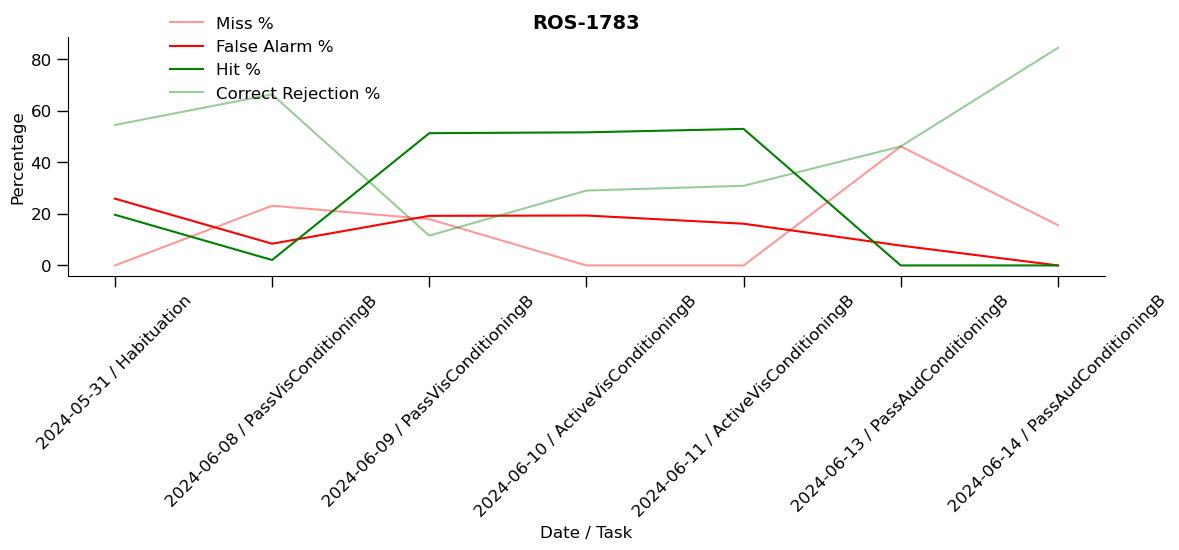

/tmp/ipykernel_1400599/1756855973.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mouse_data['Date_Task'], rotation=45)  # Rotate labels for better readability


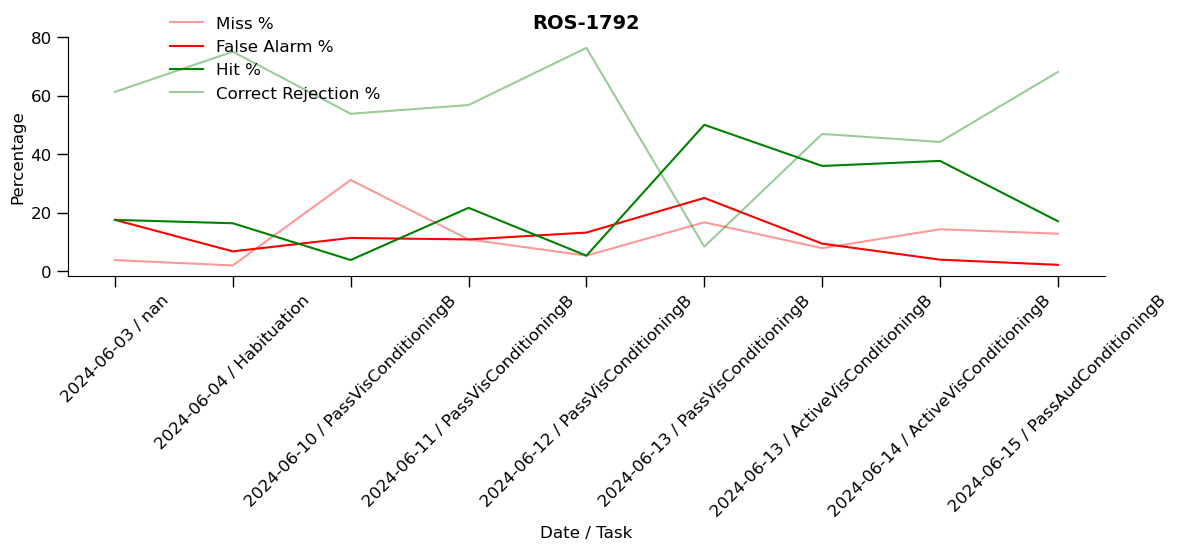

/tmp/ipykernel_1400599/1756855973.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mouse_data['Date_Task'], rotation=45)  # Rotate labels for better readability


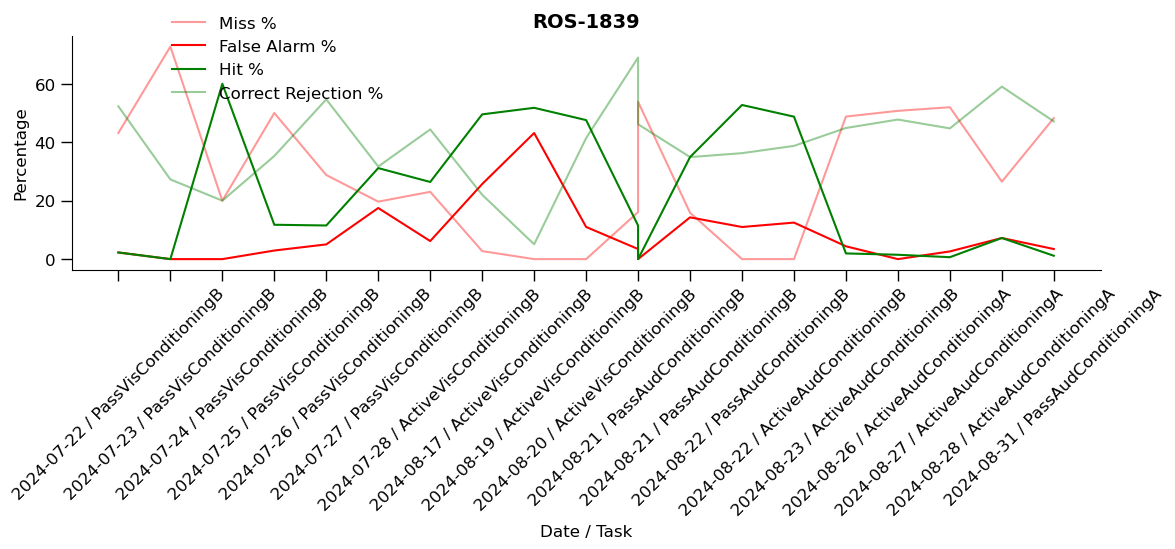

/tmp/ipykernel_1400599/1756855973.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mouse_data['Date_Task'], rotation=45)  # Rotate labels for better readability


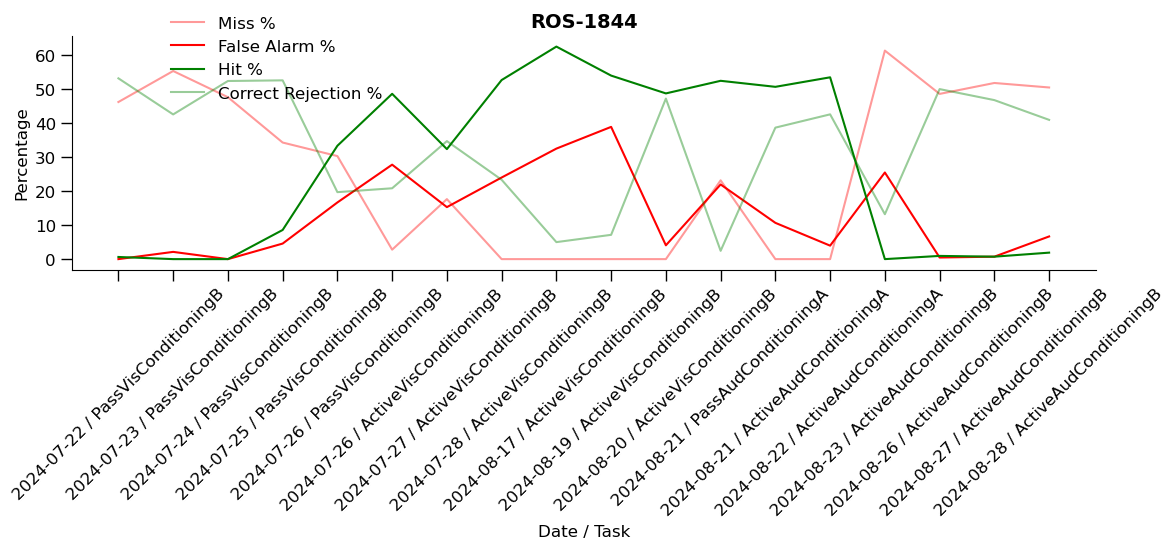

/tmp/ipykernel_1400599/1756855973.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(mouse_data['Date_Task'], rotation=45)  # Rotate labels for better readability


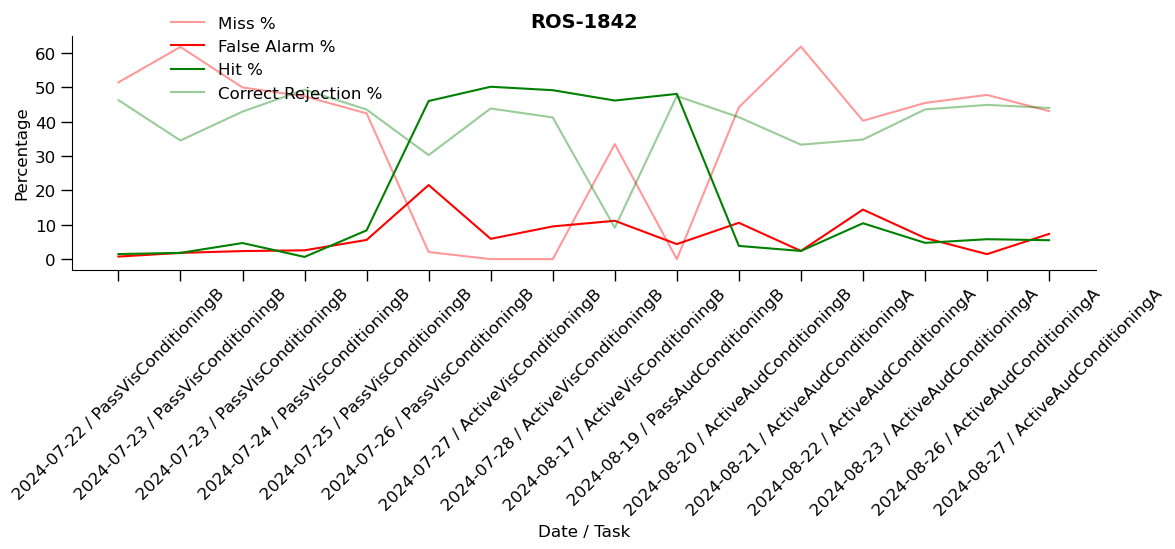

In [99]:
mice = learning_df['Mouse'].unique()
# Create a plot for each mouse
for mouse in mice:
    # Filter data for the current mouse
    mouse_data = learning_df[learning_df['Mouse'] == mouse]
    plt.rcParams['font.size'] = 12
    plt.rcParams['font.family'] = "sans-serif"
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    
    # Plotting
    fig, ax = plt.subplots(figsize=(12, 6))  # This also creates an axis object 'ax' which you can use instead of plt directly
    ax.plot(mouse_data['Date_Task'], mouse_data['Miss %'], linestyle='-', label='Miss %', color = 'red', alpha=0.4)	
    ax.plot(mouse_data['Date_Task'], mouse_data['FA %'], linestyle='-', label='False Alarm %', color = 'red')
    ax.plot(mouse_data['Date_Task'], mouse_data['Hit %'], linestyle='-', label='Hit %', color = 'green')
    ax.plot(mouse_data['Date_Task'], mouse_data['CR %'], linestyle='-', label='Correct Rejection %', color = 'green', alpha=0.4)

    # Adding titles and labels
    ax.set_title(f'{mouse}')
    ax.set_xlabel('Date / Task')
    ax.set_ylabel('Percentage')
    ax.set_xticklabels(mouse_data['Date_Task'], rotation=45)  # Rotate labels for better readability
    ax.legend(frameon=False, loc='upper center', bbox_to_anchor=(0.2, 1.15))
    ax.tick_params(labelsize = 12)
    ax.grid(False)
    fig.tight_layout()

    # Construct the path to the folder where the plot will be saved
    folder_path = os.path.join('/datajoint-data/data/aeltona', 'Learning Curves')
    file_path = os.path.join(folder_path, f'new_learning_curve_{mouse}')

    # Check if the folder exists, and create it if it does not
    # if not os.path.exists(folder_path):
    #     os.makedirs(folder_path)

    # Set the background color of the figure to white
    fig.patch.set_facecolor('white')

    # Save and show plot (make sure 'folder_path' and 'file_path' are correctly defined)
    # plt.savefig(f'{file_path}.pdf')
    # plt.savefig(f'{file_path}.png', bbox_inches='tight', facecolor=fig.get_facecolor())
    plt.show()


# Outcome plot per session

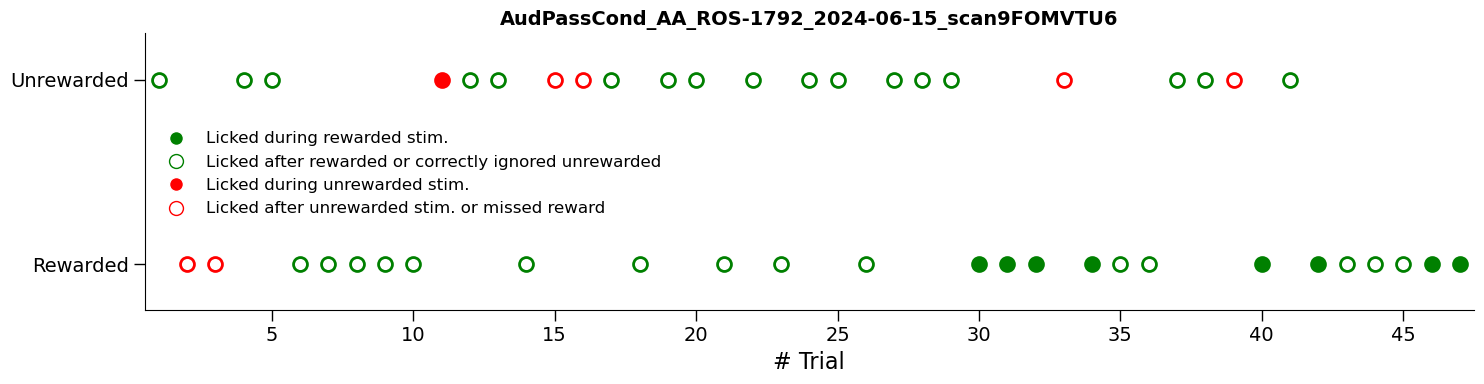

In [27]:
# Plotting setup
fig, ax = plt.subplots(figsize=(15, 4))  # Adjust the figsize to increase width and decrease height

# Define colors and markers based on outcome
color_map = { -1: 'red', 0: 'red', 1: 'green', 2: 'green' }
fill_style_map = { -1: 'none', 0: 'full', 1: 'full', 2: 'none' }

# Plot each point based on its outcome
for idx, row in outcome_df.iterrows():
    ax.plot(row['num_trial'], row['trial_type'], 'o',
            markerfacecolor=color_map[row['outcome']] if fill_style_map[row['outcome']] == 'full' else 'none',
            markeredgecolor=color_map[row['outcome']],
            markeredgewidth=2,
            markersize=10,
            fillstyle=fill_style_map[row['outcome']])

# Adjust y-axis
ax.set_yticks([1, 2])
ax.set_yticklabels(['Unrewarded', 'Rewarded'], fontsize=14)
ax.set_ylim(2.25, 0.75)  # Invert y-axis to place Type 1 on top

# Setting the axis labels and title
ax.set_xlabel('# Trial',fontsize=16)
# ax.set_ylabel('Trial Type')
ax.set_title(scan_info)  # Replace with your actual `scan_info` variable

# Adjust x-axis limits and spacing
ax.set_xlim(0.5, outcome_df['num_trial'].max() + 0.5)  # Provide a little padding
ax.tick_params(axis='x', labelsize=14)

# Create a custom legend using circle markers
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Licked during rewarded stim.',
           markerfacecolor='green', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Licked after rewarded or correctly ignored unrewarded',
           markerfacecolor='none', markeredgecolor='green', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Licked during unrewarded stim.',
           markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Licked after unrewarded stim. or missed reward',
           markerfacecolor='none', markeredgecolor='red', markersize=10)
]

# Adjust legend position to avoid overlap and make it visually pleasant
ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.4, 0.70), ncol=1, frameon=False)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))


# Show the plot
plt.tight_layout()

# Construct the path to the folder where the plot will be saved
folder_path = os.path.join('/datajoint-data/data/aeltona', 'Outcomes')
file_path = os.path.join(folder_path, f'{scan_info}_outcomes')

# Check if the folder exists, and create it if it does not
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
# Save and show plot (make sure 'folder_path' and 'file_path' are correctly defined)
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
plt.savefig(f'{file_path}.svg')
plt.savefig(f'{file_path}.png')

plt.show()

# Outcome plot per training day

In [372]:
learning_df

Mouse        Date         Task              True Task     Mode  \
0   ROS-1783  2024-06-08  PassVisCond    Visual Conditioning  Passive   
1   ROS-1783  2024-06-09  PassVisCond    Visual Conditioning  Passive   
2   ROS-1792  2024-06-10  PassVisCond    Visual Conditioning  Passive   
3   ROS-1783  2024-06-10  AtivVisCond    Visual Conditioning   Active   
4   ROS-1792  2024-06-11  PassVisCond    Visual Conditioning  Passive   
5   ROS-1783  2024-06-11  AtivVisCond    Visual Conditioning   Active   
6   ROS-1792  2024-06-12  PassVisCond    Visual Conditioning  Passive   
7   ROS-1792  2024-06-13  PassVisCond    Visual Conditioning  Passive   
8   ROS-1792  2024-06-13  AtivVisCond    Visual Conditioning   Active   
9   ROS-1783  2024-06-13  PassAudCond  Auditory Conditioning  Passive   
10  ROS-1792  2024-06-14  AtivVisCond    Visual Conditioning   Active   
11  ROS-1783  2024-06-14  PassAudCond  Auditory Conditioning  Passive   
12  ROS-1792  2024-06-15  PassAudCond  Auditory Conditioning  Passive   
13  ROS-1839  2024-07-22  PassVisCond    Visual Conditioning  Passive   
14  ROS-1844  2024-07-22  PassVisCond    Visual Conditioning  Passive   
15  ROS-1842  2024-07-22  PassVisCond    Visual Conditioning  Passive   
16  ROS-1839  2024-07-23  PassVisCond    Visual Conditioning  Passive   
17  ROS-1844  2024-07-23  PassVisCond    Visual Conditioning  Passive   
18  ROS-1842  2024-07-23  PassVisCond    Visual Conditioning  Passive   
19  ROS-1842  2024-07-23  PassVisCond    Visual Conditioning  Passive   
20  ROS-1844  2024-07-24  PassVisCond    Visual Conditioning  Passive   
21  ROS-1842  2024-07-24  PassVisCond    Visual Conditioning  Passive   
22  ROS-1839  2024-07-24  PassVisCond    Visual Conditioning  Passive   
23  ROS-1839  2024-07-25  PassVisCond    Visual Conditioning  Passive   
24  ROS-1844  2024-07-25  PassVisCond    Visual Conditioning  Passive   
25  ROS-1842  2024-07-25  PassVisCond    Visual Conditioning  Passive   
26  ROS-1839  2024-07-26  PassVisCond    Visual Conditioning  Passive   
27  ROS-1844  2024-07-26  PassVisCond    Visual Conditioning  Passive   
28  ROS-1842  2024-07-26  PassVisCond    Visual Conditioning  Passive   
29  ROS-1844  2024-07-26  AtivVisCond    Visual Conditioning   Active   
30  ROS-1839  2024-07-27  PassVisCond    Visual Conditioning  Passive   
31  ROS-1844  2024-07-27  AtivVisCond    Visual Conditioning   Active   
32  ROS-1842  2024-07-27  AtivVisCond    Visual Conditioning   Active   
33  ROS-1839  2024-07-28  AtivVisCond    Visual Conditioning   Active   
34  ROS-1842  2024-07-28  AtivVisCond    Visual Conditioning   Active   

            Scan     Miss %       FA %      Hit %       CR %  \
0   scan9FOIPM7X  23.157895   8.421053   2.105263  66.315789   
1   scan9FOJAPFP  17.948718  19.230769  51.282051  11.538462   
2   scan9FOJVAWJ  31.132075  11.320755   3.773585  53.773585   
3   scan9FOJU4V9   0.000000  19.354839  51.612903  29.032258   
4   scan9FOKEEYA  10.810811  10.810811  21.621622  56.756757   
5   scan9FOKFXB0   0.000000  16.176471  52.941176  30.882353   
6   scan9FOKYJK6   5.263158  13.157895   5.263158  76.315789   
7   scan9FOLLVZB  16.666667  25.000000  50.000000   8.333333   
8   scan9FOLMDEP   7.812500   9.375000  35.937500  46.875000   
9   scan9FOLNSC0  46.153846   7.692308   0.000000  46.153846   
10  scan9FOM3HZ3  14.285714   3.896104  37.662338  44.155844   
11  scan9FOM4GU6  15.625000   0.000000   0.000000  84.375000   
12  scan9FOMVTU6  12.765957   2.127660  17.021277  68.085106   
13  scan9FP8YFUZ  43.181818   2.272727   2.272727  52.272727   
14  scan9FP8XE9W  46.202532   0.000000   0.632911  53.164557   
15  scan9FP8ZAU1  51.470588   0.735294   1.470588  46.323529   
16  scan9FP9IRC2  72.727273   0.000000   0.000000  27.272727   
17  scan9FP9JU9Z  55.319149   2.127660   0.000000  42.553191   
18  scan9FP9KLV8  61.818182   1.818182   1.818182  34.545455   
19  scan9FP9KLV8  61.818182   1.818182   1.818182  34.545455   
20  scan9FPA3VYT  47.619048   0.00

# Plot per trials, task, mouse

In [19]:
folder_path = os.path.join('/datajoint-data/data/aeltona/', 'Learning Curves')
file_path = os.path.join(folder_path, f'trials_df.csv')
trials_df = pd.read_csv(file_path)
trials_df.shape

(7748, 8)

In [46]:
trials_df

Scan  num_trial  trial_type  outcome     Mouse  \
4587  scan9FPWSFP3        449           1       -1  ROS-1839   
4648  scan9FPWSFP3        510           2        2  ROS-1839   
4585  scan9FPWSFP3        447           2        2  ROS-1839   
4588  scan9FPWSFP3        450           2        2  ROS-1839   
4589  scan9FPWSFP3        451           2        2  ROS-1839   
...            ...        ...         ...      ...       ...   
7082  scan9FODV06V         60           1        0  ROS-1783   
7081  scan9FODV06V         59           1        0  ROS-1783   
7080  scan9FODV06V         58           1        2  ROS-1783   
7079  scan9FODV06V         57           1        0  ROS-1783   
7024  scan9FODV06V          2           1        2  ROS-1783   

                    Date                    Task  Cohort  
4587 2024-08-31 22:34:38  ActiveAudConditioningA       1  
4648 2024-08-31 22:34:38  ActiveAudConditioningA       1  
4585 2024-08-31 22:34:38  ActiveAudConditioningA       1  
4588 2024-08-31 22:34:38  ActiveAudConditioningA       1  
4589 2024-08-31 22:34:38  ActiveAudConditioningA       1  
...                  ...                     ...     ...  
7082 2024-05-31 16:21:40             Habituation       1  
7081 2024-05-31 16:21:40             Habituation       1  
7080 2024-05-31 16:21:40             Habituation       1  
7079 2024-05-31 16:21:40             Habituation       1  
7024 2024-05-31 16:21:40             Habituation       1  

[7748 rows x 8 columns]

In [43]:
color_active = {
    'Miss': {'color': 'red', 'alpha': 0.4},
    'False Alarm': {'color': 'red', 'alpha': 1},
    'Hit': {'color': 'green', 'alpha': 1},	
    'Correct Rejection': {'color': 'green', 'alpha': 0.4}
}
color_passive = {
    'Mock reward-driven lick': {'color': 'red', 'alpha': 0.4},
    'False Alarm': {'color': 'red', 'alpha': 1},
    'Hit': {'color': 'green', 'alpha': 1},	
    'Reward-driven lick': {'color': 'green', 'alpha': 0.4}
}

acronyms = {
    'Miss': 'Miss',
    'False Alarm': 'FA',
    'Hit': 'Hit',
    'Correct Rejection': 'CR',
    'Mock reward-driven lick': 'Miss',
    'Reward-driven lick': 'CR',
    
}
# Define percentage map
percentage_map = {
    -1: 'Miss',
    0: 'FA',
    1: 'Hit',
    2: 'CR'
}

task_order = ['Habituation','PassVisConditioningB','ActiveVisConditioningB','PassAudConditioningB','ActiveAudConditioningB','PassAudConditioningA','ActiveAudConditioningA', 'AudProbeB']


File /datajoint-data/data/aeltona/Learning Curves/Curves per trials/ROS-1783_Habituation.pdf already exists. Not overwriting.


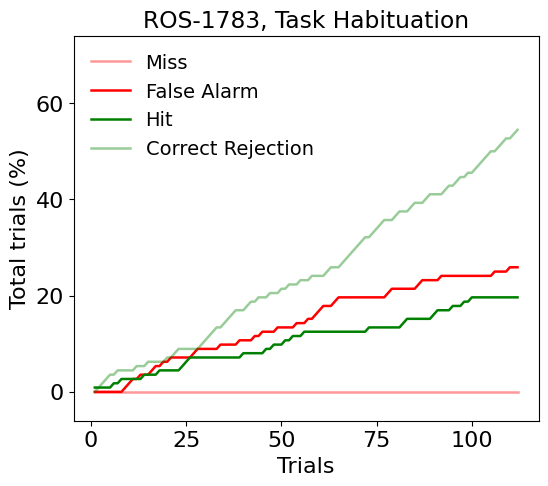

File /datajoint-data/data/aeltona/Learning Curves/Curves per trials/ROS-1792_Habituation.pdf already exists. Not overwriting.


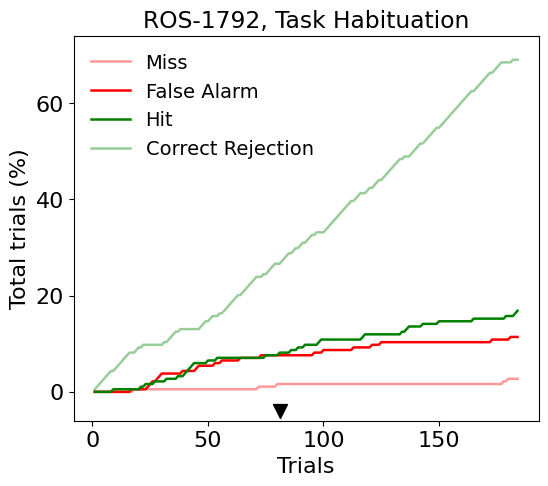

File /datajoint-data/data/aeltona/Learning Curves/Curves per trials/ROS-1783_PassVisConditioningB.pdf already exists. Not overwriting.


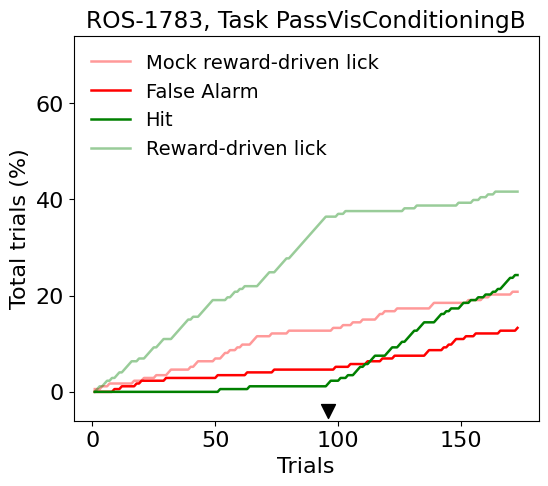

File /datajoint-data/data/aeltona/Learning Curves/Curves per trials/ROS-1792_PassVisConditioningB.pdf already exists. Not overwriting.


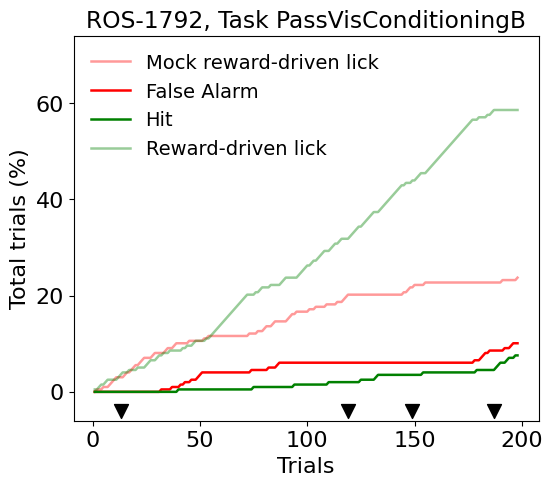

File /datajoint-data/data/aeltona/Learning Curves/Curves per trials/ROS-1839_PassVisConditioningB.pdf already exists. Not overwriting.


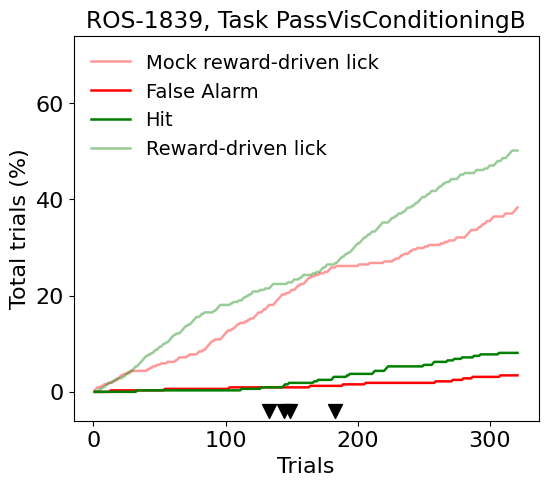

File /datajoint-data/data/aeltona/Learning Curves/Curves per trials/ROS-1842_PassVisConditioningB.pdf already exists. Not overwriting.


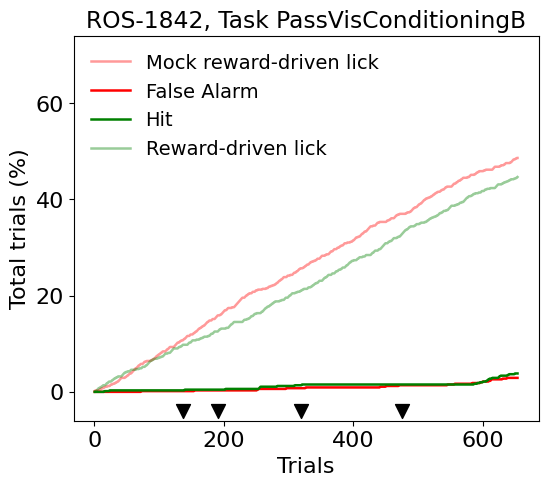

File /datajoint-data/data/aeltona/Learning Curves/Curves per trials/ROS-1844_PassVisConditioningB.pdf already exists. Not overwriting.


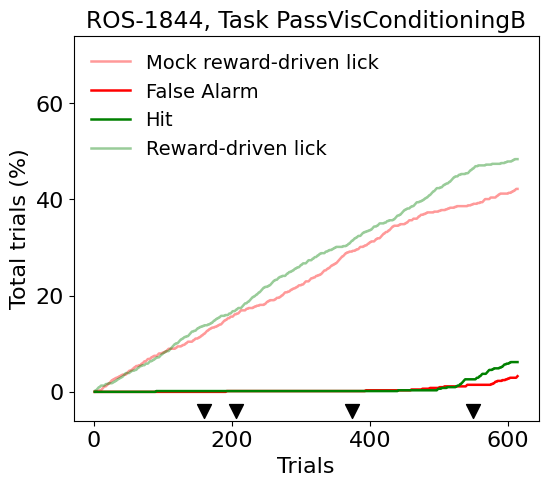

File /datajoint-data/data/aeltona/Learning Curves/Curves per trials/ROS-1783_ActiveVisConditioningB.pdf already exists. Not overwriting.


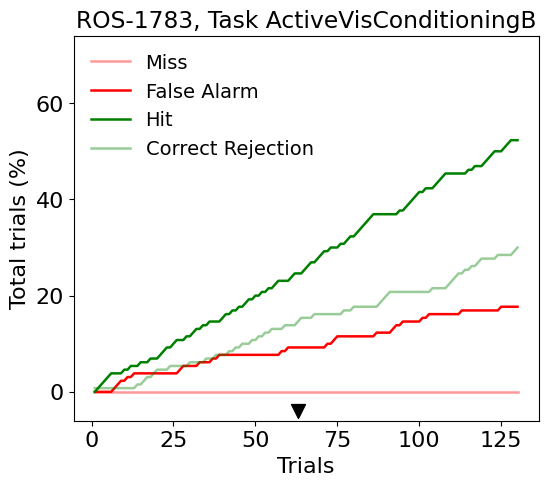

File /datajoint-data/data/aeltona/Learning Curves/Curves per trials/ROS-1792_ActiveVisConditioningB.pdf already exists. Not overwriting.


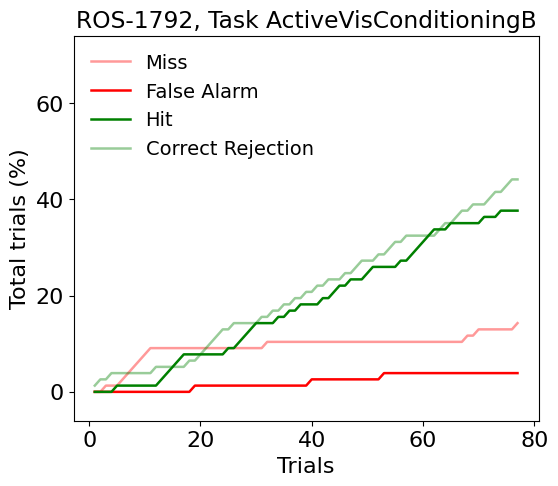

File /datajoint-data/data/aeltona/Learning Curves/Curves per trials/ROS-1839_ActiveVisConditioningB.pdf already exists. Not overwriting.


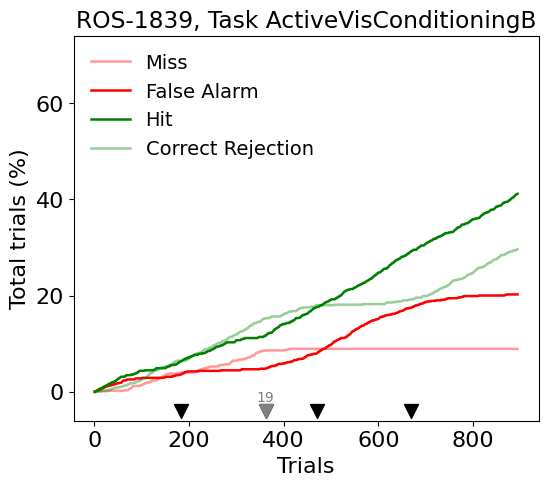

File /datajoint-data/data/aeltona/Learning Curves/Curves per trials/ROS-1842_ActiveVisConditioningB.pdf already exists. Not overwriting.


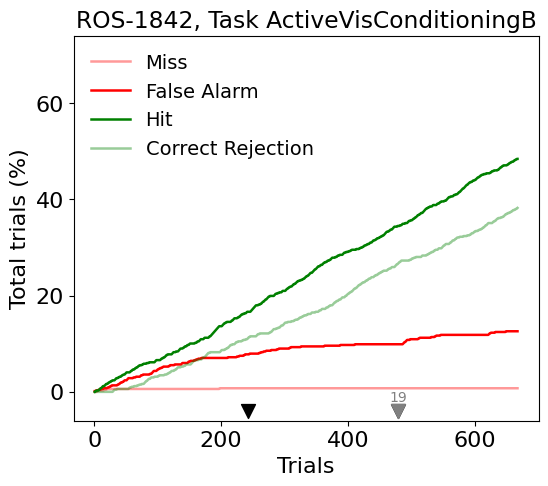

File /datajoint-data/data/aeltona/Learning Curves/Curves per trials/ROS-1844_ActiveVisConditioningB.pdf already exists. Not overwriting.


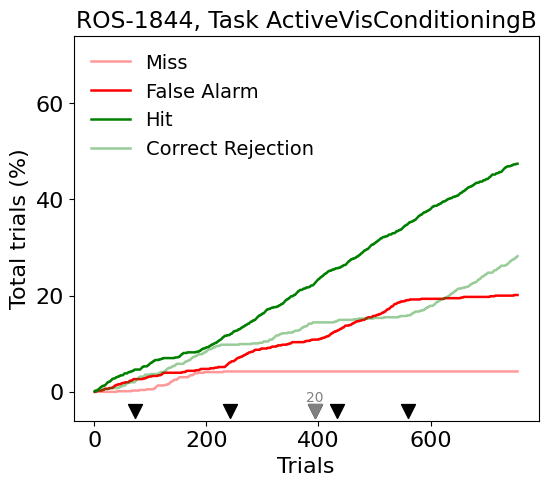

File /datajoint-data/data/aeltona/Learning Curves/Curves per trials/ROS-1839_PassAudConditioningB.pdf already exists. Not overwriting.


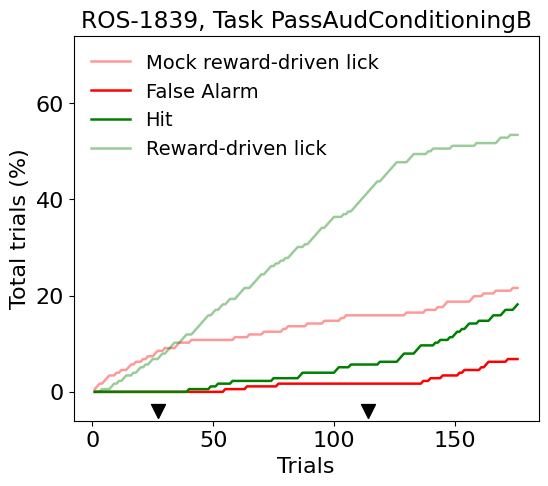

File /datajoint-data/data/aeltona/Learning Curves/Curves per trials/ROS-1842_PassAudConditioningB.pdf already exists. Not overwriting.


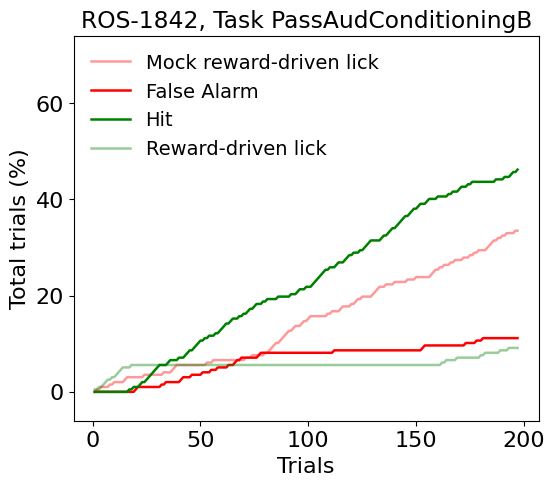

File /datajoint-data/data/aeltona/Learning Curves/Curves per trials/ROS-1839_ActiveAudConditioningB.pdf already exists. Not overwriting.


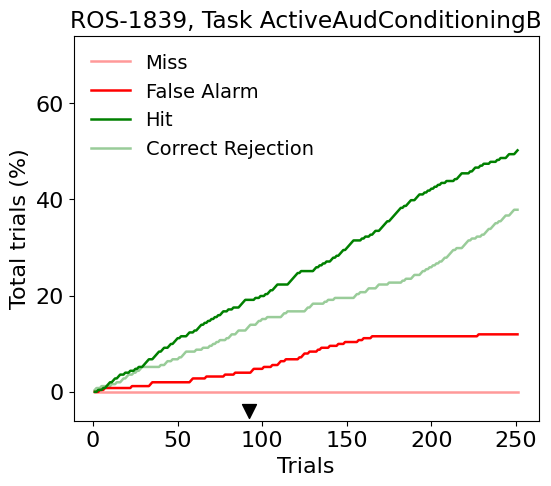

File /datajoint-data/data/aeltona/Learning Curves/Curves per trials/ROS-1842_ActiveAudConditioningB.pdf already exists. Not overwriting.


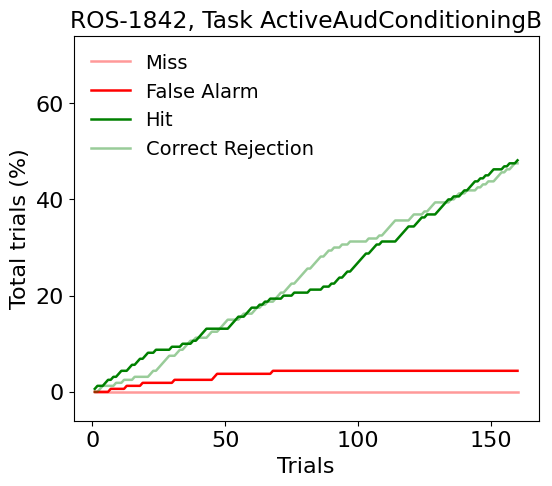

File /datajoint-data/data/aeltona/Learning Curves/Curves per trials/ROS-1844_ActiveAudConditioningB.pdf already exists. Not overwriting.


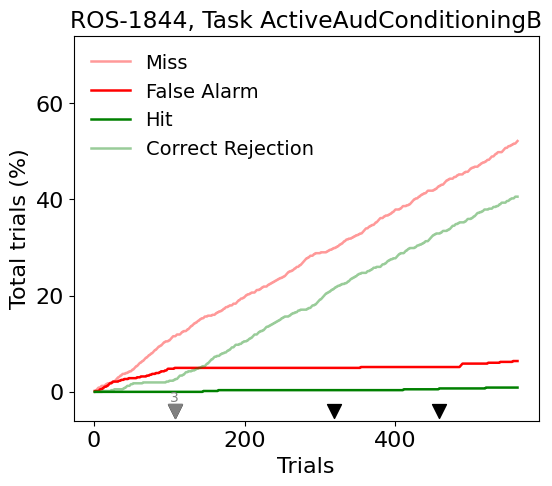

File /datajoint-data/data/aeltona/Learning Curves/Curves per trials/ROS-1839_PassAudConditioningA.pdf already exists. Not overwriting.


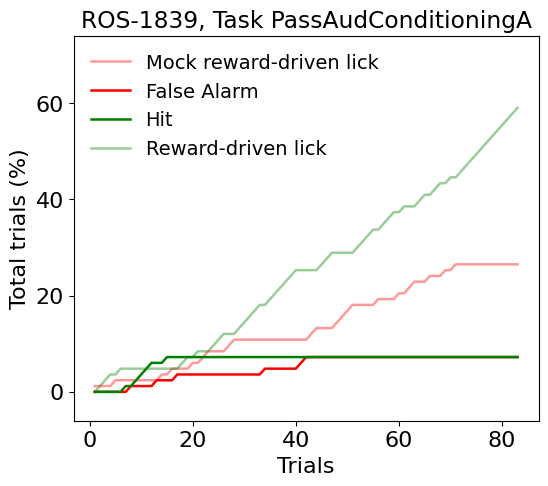

File /datajoint-data/data/aeltona/Learning Curves/Curves per trials/ROS-1844_PassAudConditioningA.pdf already exists. Not overwriting.


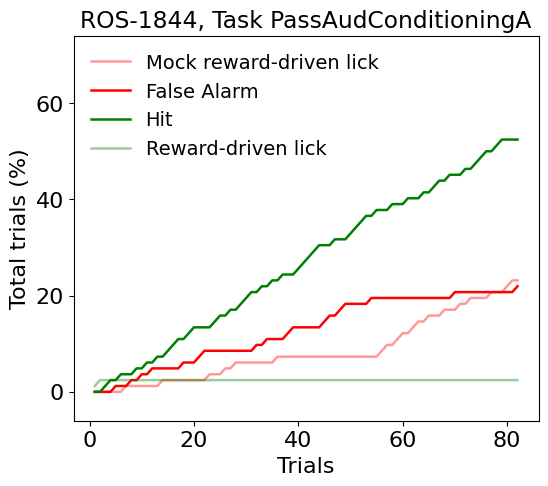

File /datajoint-data/data/aeltona/Learning Curves/Curves per trials/ROS-1839_ActiveAudConditioningA.pdf already exists. Not overwriting.


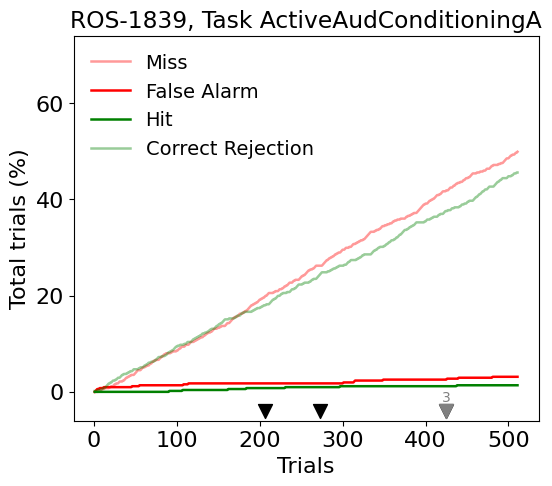

File /datajoint-data/data/aeltona/Learning Curves/Curves per trials/ROS-1842_ActiveAudConditioningA.pdf already exists. Not overwriting.


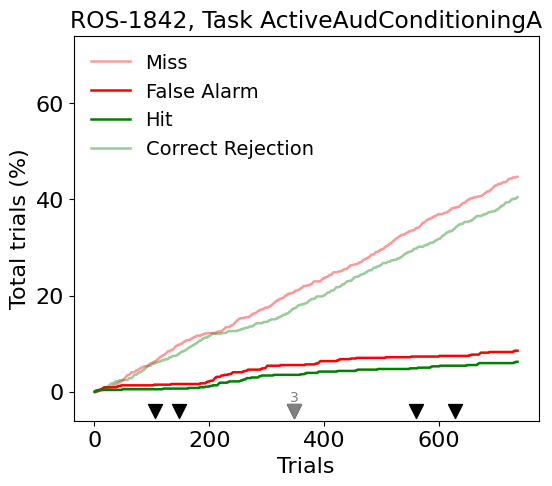

File /datajoint-data/data/aeltona/Learning Curves/Curves per trials/ROS-1844_ActiveAudConditioningA.pdf already exists. Not overwriting.


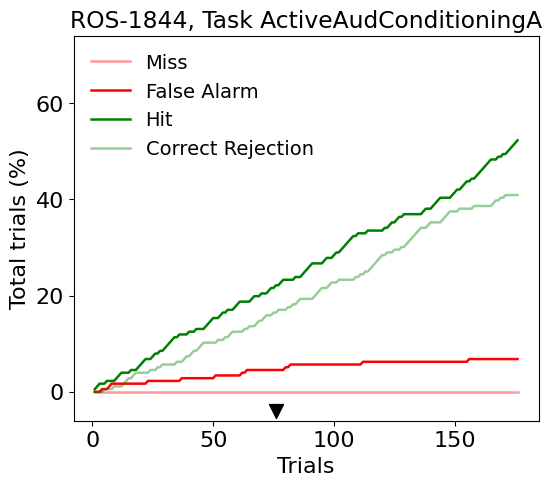

Figure saved as /datajoint-data/data/aeltona/Learning Curves/Curves per trials/ROS-1792_AudProbeB.pdf


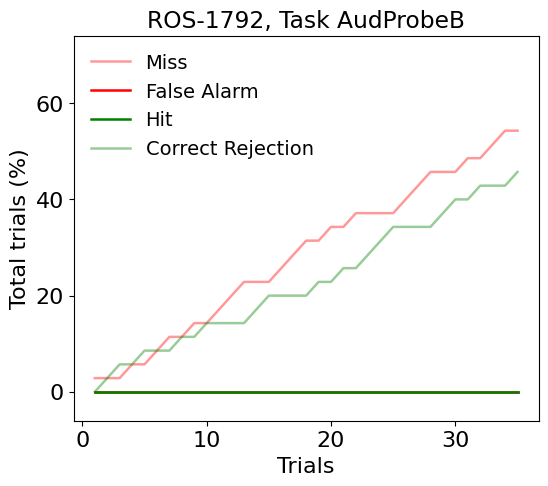

In [44]:



# Assuming trials_df is already loaded
plot_data = calculate_scaled_cumulative_percentages(trials_df, 'outcome', 'Task', 'Mouse', 'num_trial', 'Date', percentage_map)

passive_tasks = ['PassAudConditioningA','PassAudConditioningB', 'PassVisConditioningA', 'PassVisConditioningB']

global_max_y_value = 0


plot_data = sorted(plot_data, key=lambda x: task_order.index(x['task']))

for data in plot_data:
    local_max = max(
        max(data['percentages']['Miss']),
        max(data['percentages']['FA']),
        max(data['percentages']['Hit']),
        max(data['percentages']['CR'])
    )
    global_max_y_value = max(global_max_y_value, local_max)

lw = 1.8
# Plotting
fontsize = 16

yminlim = -6

folder_path = os.path.join('/datajoint-data/data/aeltona/Learning Curves', 'Curves per trials')

for data in plot_data:
    fig, ax = plt.subplots(figsize=(6, 5))  # Create a new figure for each mouse-task pair
    if data["task"] not in passive_tasks: 
        for key in color_active:
            color = color_active[key]['color']
            alpha = color_active[key]['alpha']
            ax.plot(data['num_trials'], data['percentages'][acronyms.get(key)], linestyle='-', label=f'{key}', color=color, alpha=alpha, linewidth = lw)
    else:
        for key in color_passive:
            color = color_passive[key]['color']
            alpha = color_passive[key]['alpha']
            ax.plot(data['num_trials'], data['percentages'][acronyms.get(key)], linestyle='-', label=f'{key}', color=color, alpha=alpha, linewidth = lw)

    # Add new training day markers
    for trial_num in data['new_day_trials']:
        # Plot black triangle for consecutive days
        ax.scatter(trial_num, yminlim+2, marker='v', color='black', s=100) 
    
    # Add non-consecutive day markers
    for trial_num, day_gap in data['day_gaps']:
        # Plot grey triangle for non-consecutive days
        ax.scatter(trial_num, yminlim+2, marker='v', color='grey', s=100) 
        # Plot the day gap number below the triangle
        ax.text(trial_num, yminlim+4, f'{day_gap}', color='grey', ha='center', fontsize=10)

    # Add labels, title, and legend
    ax.set_xlabel('Trials', fontsize=fontsize)
    ax.set_ylabel('Total trials (%)', fontsize=fontsize)
    ax.set_title(f'{data["mouse"]}, Task {data["task"]}')
    ax.legend(loc='upper left', frameon=False)

    ax.set_yticks([0, 20, 40, 60])

    ax.tick_params(axis='x', labelsize=fontsize)  # Increase font size of x-axis numbers
    ax.tick_params(axis='y', labelsize=fontsize)  # Increase font size of y-axis numbers


    ax.set_ylim(yminlim, global_max_y_value + 5)  # Adding a margin of 5 for readability and for triangle display
    fig.patch.set_facecolor('white')
    
    fig_name = f"{data['mouse']}_{data['task']}.pdf"
    fig_path = os.path.join(folder_path,fig_name)
    if not os.path.exists(fig_path):
        plt.savefig(fig_path)
        print(f"Figure saved as {fig_path}")
    else:
        print(f"File {fig_path} already exists. Not overwriting.")
    plt.show()
    # plt.clf()


In [102]:
# Function to fit a line for plotting and calculate the angle with x normalization for angle calculation
def fit_line_and_calculate_angle(x, y):
    from sklearn.linear_model import LinearRegression
    import numpy as np
    if len(x) > 1:  # Ensure there is enough data
        # Fit the model using the original x values for plotting
        model = LinearRegression().fit(x.reshape(-1, 1), y)
        slope = model.coef_[0]
        angle = np.degrees(np.arctan(slope))  # Calculate the angle based on the slope

        # Return the original model (for plotting) and the angle
        return model, angle
    return None, None


In [103]:


# Plotting function
def plot_learning_curves(data, global_max_y_value, trial_intervals):
    import numpy as np
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=(6, 5))
    trial_nums = np.array(data['num_trials'])
    plt.rcParams['font.size'] = 14
    plt.rcParams['font.family'] = "sans-serif"
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    # Define a dictionary for the color and alpha schemes for each outcome
    outcome_styles = {
        'Miss': {'color': 'red', 'alpha': 0.4},
        'FA': {'color': 'red', 'alpha': 1.0},
        'Hit': {'color': 'green', 'alpha': 1.0},
        'CR': {'color': 'green', 'alpha': 0.4}
    }
    # Plot trial phase boundaries
    for start, end in trial_intervals:
        if end < max(trial_nums):
            ax.axvline(x=end, color='grey', linestyle='--', linewidth=1)
        angles = []
        # offset = 45    

        for outcome in ['Hit', 'Miss', 'CR',  'FA']:
            x_segment, y_segment = trial_nums[start:end], data['percentages'][outcome][start:end]                 
            try:
                # Fit line using normalized x for angle calculation but original x for plotting
                model, angle = fit_line_and_calculate_angle(x_segment, y_segment)  
                angles.append(angle)
                if model:
                    # Plot the line using the original x values (to match your visual plot)
                    y_pred = model.predict(x_segment.reshape(-1, 1))
                    ax.plot(x_segment, y_pred, color='black',
                            linewidth = .8)
                   
            except Exception as e:
                print(f"Error fitting line for interval {start}-{end}: {e}")
        angles_array = np.array(angles)
        # sum_angles = angles_array.sum()
        offset = 48
        for angle, outcome in zip(angles, ['Hit', 'Miss', 'CR', 'FA']):
            ax.text(np.median(x_segment), offset, 
                    f'{(angle / sum(angles) * 100):.1f}', color=outcome_styles[outcome]['color'],
                    alpha=outcome_styles[outcome]['alpha'], fontsize=12, ha='center')
            offset -= 5

    # Plot raw data for outcomes with colors and alpha values from the dictionary
    for outcome in ['Hit', 'Miss', 'CR',  'FA']:
        ax.plot(trial_nums, data['percentages'][outcome], 
                color=outcome_styles[outcome]['color'], 
                alpha=outcome_styles[outcome]['alpha'], 
                linewidth=3, label=outcome)

    # Add day markers
    yminlim = -6
    ax.scatter(data['new_day_trials'], [yminlim + 2] * len(data['new_day_trials']), marker='v', color='black', s=100)
    for trial_num, day_gap in data['day_gaps']:
        ax.scatter(trial_num, yminlim + 2, marker='v', color='grey', s=100)
        ax.text(trial_num, yminlim + 4, f'{day_gap}', color='grey', ha='center', fontsize=10)

    # Configure plot
    ax.set_xlabel('Trials', fontsize=16)
    ax.set_ylabel('Total trials (%)', fontsize=16)
    ax.set_title(f'{data["mouse"]}, Task {data["task"]}')
    ax.legend(loc='upper left', frameon=False)
    ax.set_ylim(yminlim, global_max_y_value + 5)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    fig.patch.set_facecolor('white')

    plt.show()


In [105]:
# outcome_styles = {
#     'Miss': {'color': 'red', 'alpha': 0.4, 'label': 'Mock reward-driven lick' if data["task"] in passive_tasks else 'Miss'},
#     'FA': {'color': 'red', 'alpha': 1.0, 'label': 'False Alarm'},
#     'Hit': {'color': 'green', 'alpha': 1.0, 'label': 'Hit'},
#     'CR': {'color': 'green', 'alpha': 0.4, 'label': 'Reward-driven lick' if data["task"] in passive_tasks else 'Correct Rejection'}
# }
# angles = [0.5, 0.6, 0.7, 0.8]
# zip(angles, outcome_styles.items())

In [106]:

def plot_learning_curves(data, global_max_y_value, trial_intervals, passive_tasks):
    fig, ax = plt.subplots(figsize=(6, 5))
    trial_nums = np.array(data['num_trials'])
    plt.rcParams['font.size'] = 14
    plt.rcParams['font.family'] = "sans-serif"
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42

    # Define a dictionary for the color and alpha schemes for each outcome
    outcome_styles = {
        'Miss': {'color': 'red', 'alpha': 0.4, 'label': 'Mock reward-driven lick' if data["task"] in passive_tasks else 'Miss'},
        'FA': {'color': 'red', 'alpha': 1.0, 'label': 'False Alarm'},
        'Hit': {'color': 'green', 'alpha': 1.0, 'label': 'Hit'},
        'CR': {'color': 'green', 'alpha': 0.4, 'label': 'Reward-driven lick' if data["task"] in passive_tasks else 'Correct Rejection'}
    }
    y_stop = 48
    # Plot trial phase boundaries
    for start, end in trial_intervals:
        if end < max(trial_nums):
            # ax.axvline(x=end, color='grey', linestyle='--', linewidth=1)
            ax.plot([end, end], [0, y_stop], color='grey', linestyle='--', linewidth=1)

        angles = []
    
    # Plotting each outcome
        for outcome, style in outcome_styles.items():
            # ax.plot(data['num_trials'], data['percentages'][outcome], linestyle='-',
            #         label=f"{style['label']}",
            #         color=style['color'], alpha=style['alpha'])
            x_segment, y_segment = trial_nums[start:end], data['percentages'][outcome][start:end]                 
            try:
                # Fit line using normalized x for angle calculation but original x for plotting
                model, angle = fit_line_and_calculate_angle(x_segment, y_segment)  
                angles.append(angle)
                # if model:
                #     # Plot the line using the original x values (to match your visual plot)
                #     y_pred = model.predict(x_segment.reshape(-1, 1))
                #     ax.plot(x_segment, y_pred, color='black',
                #             linewidth = .8)
                    
            except Exception as e:
                print(f"Error fitting line for interval {start}-{end}: {e}")
        offset = 45
        x_segment = trial_nums[start:end]                 

        segment_size = x_segment[-1] - x_segment[0]
        if segment_size > 30:
            for angle, (outcome, style) in zip(angles, outcome_styles.items()):
                ax.text(np.median(x_segment), offset, 
                        f'{(angle / sum(angles) * 100):.1f}', color=style['color'], alpha=style['alpha'],
                        fontsize=12, ha='center')
                offset -= 5
    for outcome, style in outcome_styles.items():
        ax.plot(data['num_trials'], data['percentages'][outcome], linestyle='-',
                label=f"{style['label']}",
                color=style['color'], alpha=style['alpha'])
    # Additional elements: day markers and labels
    yminlim = -6
    ax.scatter(data['new_day_trials'], [yminlim + 2] * len(data['new_day_trials']), marker='v', color='black', s=100)
    for trial_num, day_gap in data['day_gaps']:
        ax.scatter(trial_num, yminlim + 2, marker='v', color='grey', s=100)
        ax.text(trial_num, yminlim + 4, f'{day_gap}', color='grey', ha='center', fontsize=10)

    # Configure plot aesthetics
    ax.set_xlabel('Trials', fontsize=16)
    ax.set_ylabel('Total trials (%)', fontsize=16)
    ax.set_title(f'{data["mouse"]}, Task {data["task"]}')
    ax.legend(loc='upper left', frameon=False)
    ax.set_ylim(yminlim, global_max_y_value + 5)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    fig.patch.set_facecolor('white')

    # plt.show()


Folder /datajoint-data/data/aeltona/Learning Curves/Curves per trials_New already exists.
Figure saved as /home/aeltona/wfield/notebooks/TAC figs/ROS-1792_AudProbeB.pdf


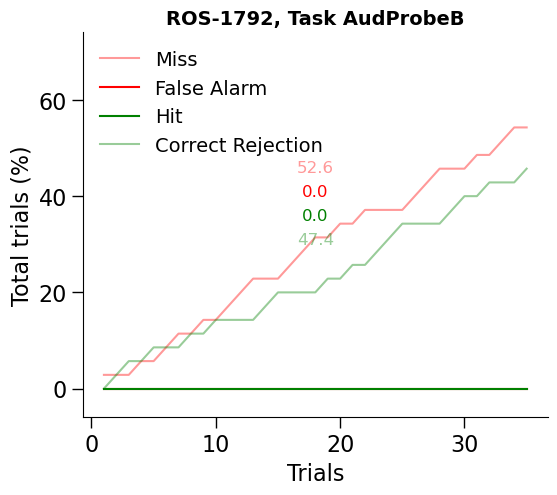

In [109]:
trials_df['Date'] = trials_df['Scan'].apply(lambda x: decode_base36_timestamp(x.replace('scan', '')))
trials_df = trials_df.sort_values(by='Date', ascending=False)
percentage_map = {
    -1: 'Miss',
    0: 'FA',
    1: 'Hit',
    2: 'CR'
}
plot_data = calculate_scaled_cumulative_percentages(trials_df, 'outcome', 'Task', 'Mouse', 'num_trial', 'Date', percentage_map)
passive_tasks = ['PassAudConditioningA','PassAudConditioningB', 'PassVisConditioningA', 'PassVisConditioningB']
tasks_to_plot = ['AudProbeB']
tasks_tonot_plot = 'Habituation'
global_max_y_value = max(max(data['percentages'][o]) for data in plot_data for o in ['Miss', 'FA', 'Hit', 'CR'])
max_trials = max(max(data['num_trials']) for data in plot_data if data['task'] in tasks_to_plot)

real_folder_path = os.path.join('/datajoint-data/data/aeltona/Learning Curves', 'Curves per trials_New')
temp_folder_path = os.path.join('/home/aeltona/wfield/notebooks/TAC figs')

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print(f"Folder {folder_path} created.")
else:
    print(f"Folder {folder_path} already exists.")

for data in plot_data:  
    if data['task'] in tasks_to_plot: #and data['mouse'] in ['ROS-1792']:
        trial_intervals = []
        if data.get('new_day_trials'):  # Safeguard with .get() in case 'day_gaps' key is missing
            trial_nums = [trial_num for trial_num in data['new_day_trials']]
            first_trial_num = trial_nums[0]
            trial_intervals.append((0, first_trial_num))
            for i in range(len(trial_nums)-1):
                current_trial_num = trial_nums[i]
                next_trial_num = trial_nums[i +1]
                trial_intervals.append((current_trial_num + 1, next_trial_num))
            last_trial_num = trial_nums[-1]
            trial_intervals.append((last_trial_num + 1, 1000))
        max_trials = max(data['num_trials'])
        if trial_intervals == []:
            trial_intervals = [(0, max_trials)]   
        plot_learning_curves(data, global_max_y_value, trial_intervals, passive_tasks)

        
        fig_name = f"{data['mouse']}_{data['task']}.pdf"
        real_fig_path = os.path.join(real_folder_path,fig_name)
        temp_fig_path = os.path.join(temp_folder_path,fig_name)
        if not os.path.exists(temp_fig_path):
            plt.savefig(temp_fig_path)
            print(f"Figure saved as {temp_fig_path}")
            plt.show()
        else:
            print(f"File {temp_fig_path} already exists. Not overwriting and clearing plot.")
            plt.clf();
        

In [286]:
# # Assuming trials_df and plot_data are already defined

# # Define trial intervals (learning phases)
# trial_intervals = [(0, 180), (181, 600)]  # Example trial intervals

# # Colors for each phase
# colors = ['blue', 'orange', 'green']
# global_max_y_value = 0

# # Loop over the data to create the plots
# for data in plot_data:
#     fig, ax = plt.subplots(figsize=(6, 5))  # Create a new figure for each mouse-task pair

#     trial_nums = np.array(data['num_trials'])  # X-axis (trials)
#     percentages = np.array(data['percentages']['Hit'])  # Example for 'Hit' percentage (Y-axis)

#     # Adjust global max y value for consistency across all plots
#     local_max = max(
#         max(data['percentages']['Miss']),
#         max(data['percentages']['FA']),
#         max(data['percentages']['Hit']),
#         max(data['percentages']['CR'])
#     )
#     global_max_y_value = max(global_max_y_value, local_max)
    
#     # Draw vertical dashed grey lines at the boundaries of each interval
#     for i, (start, end) in enumerate(trial_intervals):
#         if end < max(trial_nums):  # Ensure the end boundary is within trial range
#             ax.axvline(x=end, color='grey', linestyle='--', linewidth=1)

#     # Fit and plot lines for each trial segment
#     for i, (start, end) in enumerate(trial_intervals):
#         x_segment = trial_nums[start:end]
#         y_segment = percentages[start:end]

#         try:
#             # Fit line and calculate angle
#             model, angle = fit_line_and_calculate_angle(x_segment, y_segment)
#             y_pred = model.predict(np.array(x_segment).reshape(-1, 1))

#             # Plot the fitted line
#             ax.plot(x_segment, y_pred, color=colors[i], label=f'Phase {i+1} (angle={angle:.2f}°)')

#             # Add angle annotation
#             mid_x = np.median(x_segment)
#             mid_y = np.median(y_pred)
#             ax.text(mid_x, mid_y, f'{angle:.2f}°', color=colors[i], fontsize=12, ha='center')
#         except Exception as e:
#             print(f"Error fitting line for phase {i+1}: {e}")
#     # Plot the raw data for 'Hit', 'Miss', 'FA', 'CR'
#     ax.plot(trial_nums, data['percentages']['Miss'], linestyle='-', label=f'Miss', color='red', alpha=0.4, linewidth=1.8)
#     ax.plot(trial_nums, data['percentages']['FA'], linestyle='-', label=f'False Alarm', color='red', linewidth=1.8)
#     ax.plot(trial_nums, data['percentages']['Hit'], linestyle='-', label=f'Hit', color='green', linewidth=1.8)
#     ax.plot(trial_nums, data['percentages']['CR'], linestyle='-', label=f'Correct Rejection', color='green', alpha=0.4, linewidth=1.8)

#     # Add new training day markers
#     yminlim = -6
#     for trial_num in data['new_day_trials']:
#         ax.scatter(trial_num, yminlim+2, marker='v', color='black', s=100) 
    
#     # Add non-consecutive day markers
#     for trial_num, day_gap in data['day_gaps']:
#         ax.scatter(trial_num, yminlim+2, marker='v', color='grey', s=100) 
#         ax.text(trial_num, yminlim+4, f'{day_gap}', color='grey', ha='center', fontsize=10)

#     # Add labels, title, and legend
#     ax.set_xlabel('Trials', fontsize=16)
#     ax.set_ylabel('Total trials (%)', fontsize=16)
#     ax.set_title(f'{data["mouse"]}, Task {data["task"]}')
#     ax.legend(loc='upper left', frameon=False)

#     ax.set_yticks([0, 20, 40, 60])

#     ax.tick_params(axis='x', labelsize=16)  # Increase font size of x-axis numbers
#     ax.tick_params(axis='y', labelsize=16)  # Increase font size of y-axis numbers

#     # Set y-limits based on global max for consistent plots
#     ax.set_ylim(yminlim, global_max_y_value + 5)

#     # Save the figure
#     fig_name = f"{data['mouse']}_{data['task']}.pdf"
#     folder_path = '/datajoint-data/data/aeltona/Learning Curves/Curves per trials'
#     fig_path = os.path.join(folder_path, fig_name)

#     # if not os.path.exists(fig_path):
#     #     plt.savefig(fig_path)
#     #     print(f"Figure saved as {fig_path}")
#     # else:
#     #     print(f"File {fig_path} already exists. Not overwriting.")
#     plt.show()

In [ ]:
# Define percentage map
percentage_map = {
    -1: 'Miss',
    0: 'FA',
    1: 'Hit',
    2: 'CR'
}
trials_df['Date'] = pd.to_datetime(trials_df['Date'])

# Assuming trials_df is already loaded
plot_data = calculate_scaled_cumulative_percentages(trials_df, 'outcome', 'Task', 'Mouse', 'num_trial', 'Date', percentage_map)

passive_tasks = ['PassAudConditioningA','PassAudConditioningB', 'PassVisConditioningA', 'PassVisConditioningB']

global_max_y_value = 0


for data in plot_data:
    local_max = max(
        max(data['percentages']['Miss']),
        max(data['percentages']['FA']),
        max(data['percentages']['Hit']),
        max(data['percentages']['CR'])
    )
    global_max_y_value = max(global_max_y_value, local_max)

# Plotting
for data in plot_data:
    fig, ax = plt.subplots(figsize=(8, 5))  # Create a new figure for each mouse-task pair
    if data["task"] not in passive_tasks: 
    # Plot each outcome with its respective color and style
        ax.plot(data['num_trials'], data['percentages']['Miss'], linestyle='-', label=f'Miss %', color='red', alpha=0.4) #  (Final: {data["final_percentages"]["Miss"]:.1f}%)
        ax.plot(data['num_trials'], data['percentages']['FA'], linestyle='-', label=f'False Alarm %', color='red') # (Final: {data["final_percentages"]["FA"]:.1f}%)
        ax.plot(data['num_trials'], data['percentages']['Hit'], linestyle='-', label=f'Hit %', color='green') # (Final: {data["final_percentages"]["Hit"]:.1f}%)
        ax.plot(data['num_trials'], data['percentages']['CR'], linestyle='-', label=f'Correct Rejection %', color='green', alpha=0.4) #  (Final: {data["final_percentages"]["CR"]:.1f}%)
    else:
        ax.plot(data['num_trials'], data['percentages']['Miss'], linestyle='-', label=f'Mock reward-driven lick %', color='red', alpha=0.4) # (Final: {data["final_percentages"]["Miss"]:.1f}%)
        ax.plot(data['num_trials'], data['percentages']['FA'], linestyle='-', label=f'False Alarm %', color='red') #  (Final: {data["final_percentages"]["FA"]:.1f}%)
        ax.plot(data['num_trials'], data['percentages']['Hit'], linestyle='-', label=f'Hit %', color='green') #  (Final: {data["final_percentages"]["Hit"]:.1f}%)
        ax.plot(data['num_trials'], data['percentages']['CR'], linestyle='-', label=f'Reward-driven lick %', color='green', alpha=0.4) #  (Final: {data["final_percentages"]["CR"]:.1f}%)

    # Add labels, title, and legend
    ax.set_xlabel('Number of Trials')
    ax.set_ylabel('Percentage (%)')
    ax.set_title(f'{data["mouse"]}, Task {data["task"]}')
    ax.legend(loc='upper left', frameon=False) 

    ax.set_ylim(0, global_max_y_value + 5)  # Adding a margin of 5 for readability
    fig.patch.set_facecolor('white')


    # Show the plot
    plt.show()

## non linear 

In [306]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np

# Function to fit a non-linear model (polynomial) for angle calculation
def fit_nonlinear_and_calculate_angle(x, y, degree=2):
    if len(x) > 1:  # Ensure there is enough data
        # Reshape x for polynomial fitting
        x = x.reshape(-1, 1)
        
        # Fit a polynomial regression model
        poly = PolynomialFeatures(degree)
        x_poly = poly.fit_transform(x)
        model = LinearRegression().fit(x_poly, y)
        
        # Derivative at the midpoint of the interval (to approximate slope)
        midpoint = np.median(x)
        midpoint_poly = poly.transform(np.array([[midpoint]]))
        slope = model.coef_[1]  # First order term gives the slope (dx/dy)
        
        # Calculate the angle using the slope
        angle = np.degrees(np.arctan(slope))

        return model, angle
    return None, None


In [307]:
def calculate_scaled_cumulative_percentages(df, outcome_col, task_col, mouse_col, trial_col, date_col, outcome_map, type_col):
    # Group by mouse and task
    grouped = df.groupby([mouse_col, task_col])
    
    plot_data = []
    
    # Loop through each group (mouse-task pair)
    for (mouse, task), group in grouped:
        # Sort by Date to ensure chronological order
        group = group.sort_values(by=[date_col, trial_col])
        
        # Calculate final percentage for each outcome type at the last trial
        total_trials = len(group)
        final_outcome_counts = group[outcome_col].value_counts(normalize=True).to_dict()
        
        # Normalize final outcome counts to percentages
        final_percentages = {outcome_map.get(key, key): final_outcome_counts.get(key, 0) * 100 for key in outcome_map}
        
        # Initialize cumulative counters
        cumulative_counts = {outcome: 0 for outcome in outcome_map.values()}
        cumulative_scaled_percentages = {outcome: [] for outcome in outcome_map.values()}
        
        # Initialize lists to store the trial numbers and gaps in days for new training days
        new_day_trials = []
        day_gaps = []
        last_date = None

        # Loop through trials and calculate cumulative scaled percentage
        for index, row in group.iterrows():
            outcome = outcome_map[row[outcome_col]]
            cumulative_counts[outcome] += 1
            
            # Check if a new training day has started
            current_date = row[date_col]
            if last_date is not None and current_date != last_date:
                # Store the trial number of the new day
                new_day_trials.append(row[trial_col])
                
                # Calculate the gap in days if the days are not consecutive
                date_diff = (current_date - last_date).days
                if date_diff > 1:
                    day_gaps.append((row[trial_col], date_diff))  # Store the gap as (trial number, gap in days)
                
            # Update last date
            last_date = current_date
            
            # Calculate scaled cumulative percentages based on the final percentage
            for outcome_key in cumulative_scaled_percentages:
                final_percentage = final_percentages[outcome_key]
                scaled_percentage = (cumulative_counts[outcome_key] / total_trials) * 100
                cumulative_scaled_percentages[outcome_key].append(scaled_percentage)
        
        # Append data for plotting, including trial type
        plot_data.append({
            'mouse': mouse,
            'task': task,
            'num_trials': group[trial_col],
            'percentages': cumulative_scaled_percentages,
            'final_percentages': final_percentages,
            'new_day_trials': new_day_trials,  # Store the trial numbers of new training days
            'day_gaps': day_gaps,  # Store gaps as (trial number, gap in days)
            'trial_type': group[type_col].values  # Include trial type information
        })
    
    return plot_data


In [308]:
def plot_learning_curves(data, global_max_y_value, trial_intervals):
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.linear_model import LinearRegression

    fig, ax = plt.subplots(figsize=(6, 5))
    trial_nums = np.array(data['num_trials'])
    
    # Define colors and alphas for the outcomes
    outcome_styles = {
        'Miss': {'color': 'red', 'alpha': 0.4},
        'FA': {'color': 'red', 'alpha': 1.0},
        'Hit': {'color': 'green', 'alpha': 1.0},
        'CR': {'color': 'green', 'alpha': 0.4}
    }

    # Plot trial phase boundaries
    for start, end in trial_intervals:
        if end < max(trial_nums):
            ax.axvline(x=end, color='grey', linestyle='--', linewidth=1)

        angles = []

        for outcome in ['Hit', 'Miss', 'CR', 'FA']:
            x_segment = trial_nums[start:end]
            y_segment = data['percentages'][outcome][start:end]

            try:
                # Fit a polynomial model (degree=2 by default) and calculate the angle
                model, angle = fit_nonlinear_and_calculate_angle(x_segment, y_segment, degree=2)
                angles.append(angle)
                if model:
                    # Plot the fitted line for this outcome, using its corresponding color and alpha
                    poly = PolynomialFeatures(degree=2)
                    y_pred = model.predict(poly.fit_transform(x_segment.reshape(-1, 1)))
                    ax.plot(x_segment, y_pred, color=outcome_styles[outcome]['color'],
                            alpha=outcome_styles[outcome]['alpha'], linewidth=0.8)

            except Exception as e:
                print(f"Error fitting line for interval {start}-{end}: {e}")

        # Display the angles as percentages of the total sum of angles
        angles_array = np.array(angles)
        sum_angles = angles_array.sum()

        offset = 45
        for angle, outcome in zip(angles, ['Hit', 'Miss', 'CR', 'FA']):
            # Display the normalized angle as a percentage of the total angle sum
            ax.text(np.median(x_segment), offset, 
                    f'{(angle / sum_angles * 100):.1f}', color=outcome_styles[outcome]['color'],
                    alpha=outcome_styles[outcome]['alpha'], fontsize=12, ha='center')
            offset -= 5

    # Plot the raw data for each outcome with their colors and alpha values
    for outcome in ['Hit', 'Miss', 'CR', 'FA']:
        ax.plot(trial_nums, data['percentages'][outcome], 
                color=outcome_styles[outcome]['color'], 
                alpha=outcome_styles[outcome]['alpha'], 
                linewidth=3, label=outcome)

    # Add markers for new training days
    yminlim = -6
    ax.scatter(data['new_day_trials'], [yminlim + 2] * len(data['new_day_trials']), marker='v', color='black', s=100)
    for trial_num, day_gap in data['day_gaps']:
        ax.scatter(trial_num, yminlim + 2, marker='v', color='grey', s=100)
        ax.text(trial_num, yminlim + 4, f'{day_gap}', color='grey', ha='center', fontsize=10)

    # Configure plot
    ax.set_xlabel('Trials', fontsize=16)
    ax.set_ylabel('Total trials (%)', fontsize=16)
    ax.set_title(f'{data["mouse"]}, Task {data["task"]}')
    ax.legend(loc='upper left', frameon=False)
    ax.set_ylim(yminlim, global_max_y_value + 5)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

    plt.show()


In [309]:
folder_path = os.path.join('/datajoint-data/data/aeltona/', 'Learning Curves')
file_path = os.path.join(folder_path, f'trials_df.csv')
trials_df = pd.read_csv(file_path)
trials_df.shape

(7713, 8)

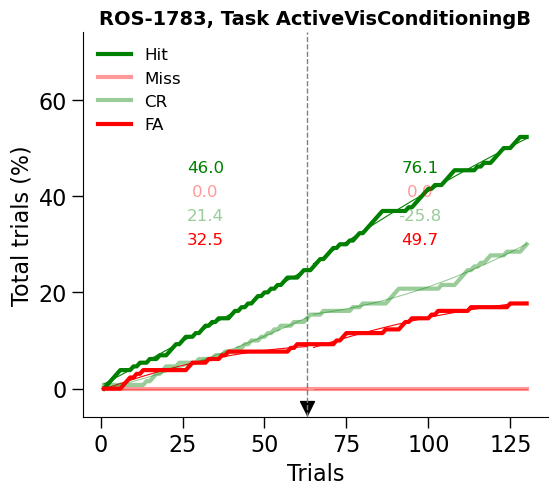

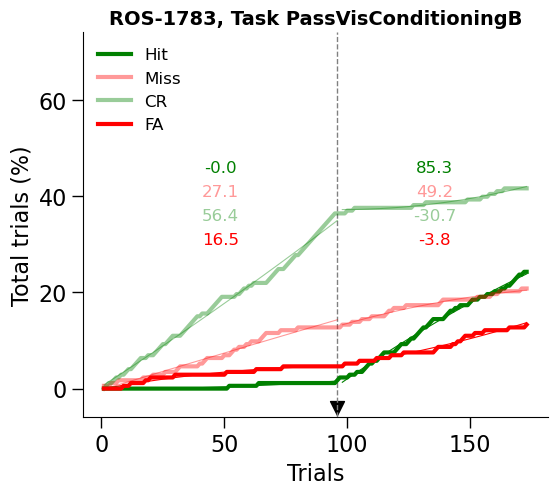

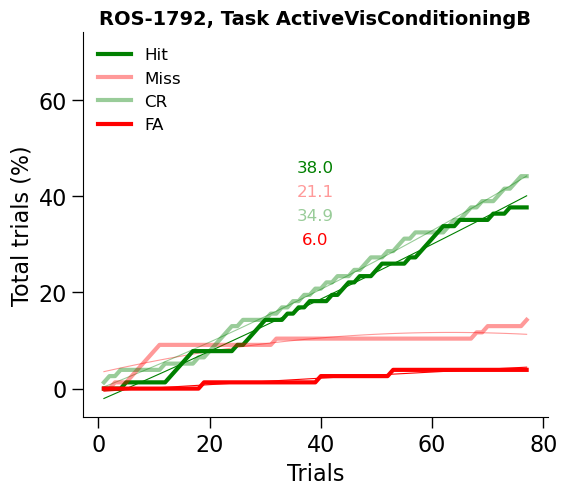

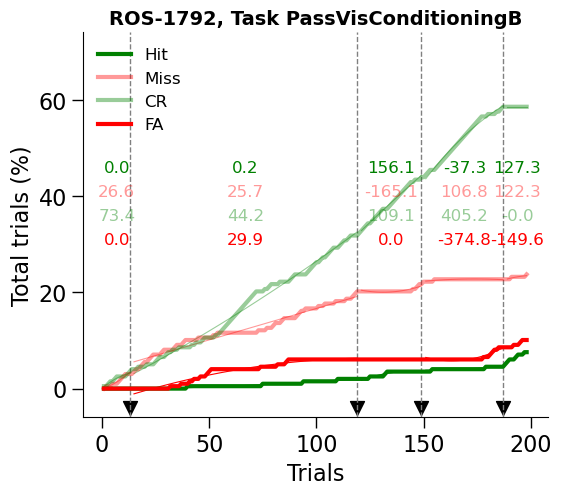

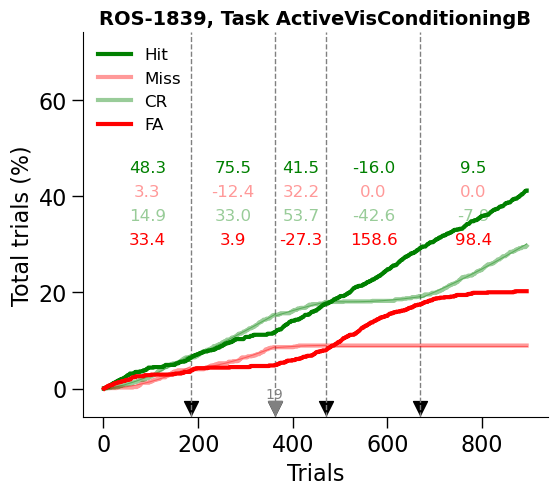

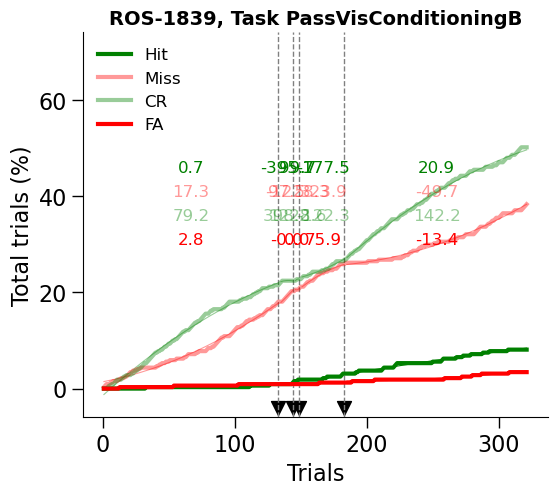

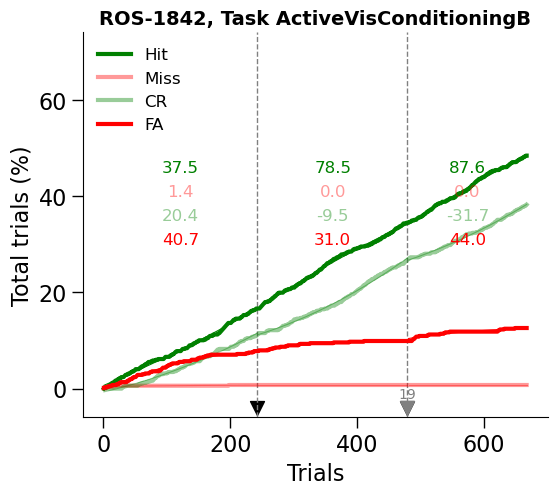

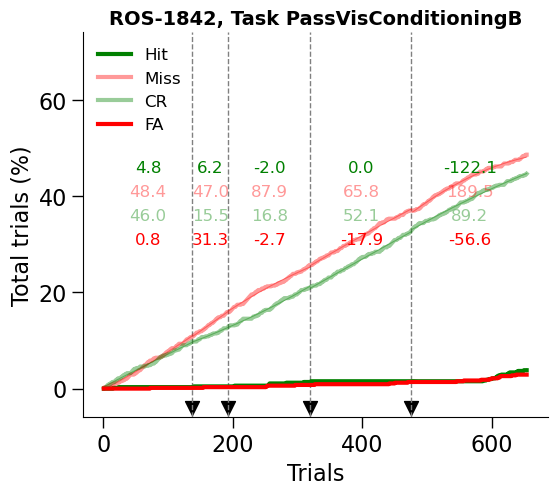

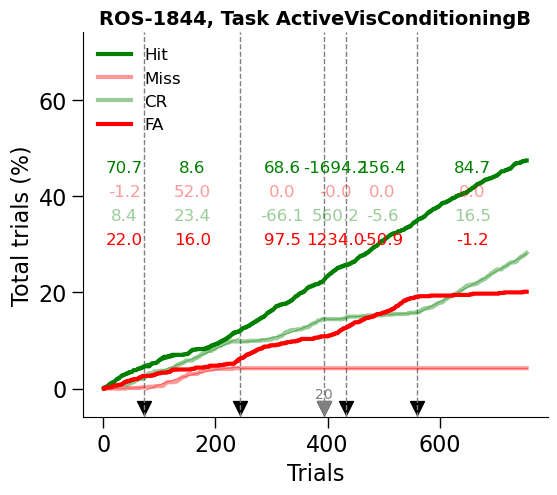

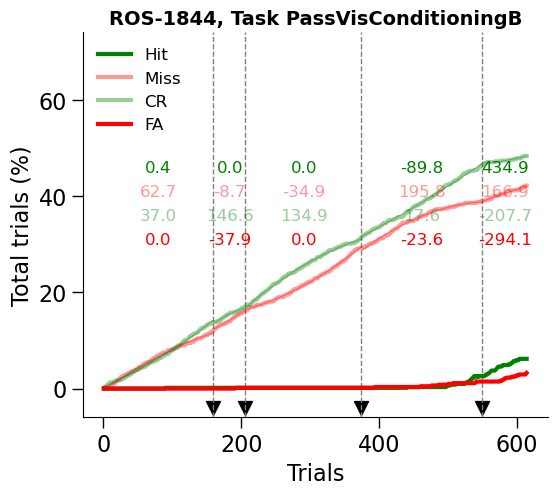

In [310]:
trials_df['Date'] = trials_df['Scan'].apply(lambda x: decode_base36_timestamp(x.replace('scan', '')))
trials_df = trials_df.sort_values(by='Date', ascending=False)

# Define percentage map
percentage_map = {
    -1: 'Miss',
    0: 'FA',
    1: 'Hit',
    2: 'CR'
}

plot_data = calculate_scaled_cumulative_percentages(trials_df, 'outcome', 'Task', 'Mouse', 'num_trial', 'Date', percentage_map, 'trial_type')

for data in plot_data:
    
    if data['task'] in tasks_to_plot:# and data['mouse'] in ['ROS-1844']:
        trial_intervals = []

        # Check if data['day_gaps'] contains valid entries
        if data.get('new_day_trials'):  # Safeguard with .get() in case 'day_gaps' key is missing
            # Extract the trial_num values from data['day_gaps']
            trial_nums = [trial_num for trial_num in data['new_day_trials']]

            # Handle the first interval (0 to first trial_num)
            first_trial_num = trial_nums[0]
            trial_intervals.append((0, first_trial_num))

            # Iterate through the trial_nums to generate subsequent intervals
            for i in range(len(trial_nums)-1):
                current_trial_num = trial_nums[i]
                next_trial_num = trial_nums[i +1]
                trial_intervals.append((current_trial_num + 1, next_trial_num))

            # Optionally handle the last interval (if you want to extend the last one)
            last_trial_num = trial_nums[-1]
            trial_intervals.append((last_trial_num + 1, 1000))
        # print(trial_intervals) 
        max_trials = max(data['num_trials'])
        if trial_intervals == []:
            trial_intervals = [(0, max_trials)] 
    if data['task'] in tasks_to_plot:  # Only plot tasks of interest
        # trial_intervals = [(0, 100), (101, 200), (201, 300)]  # Define your trial intervals
        plot_learning_curves(data, global_max_y_value, trial_intervals)


## examples

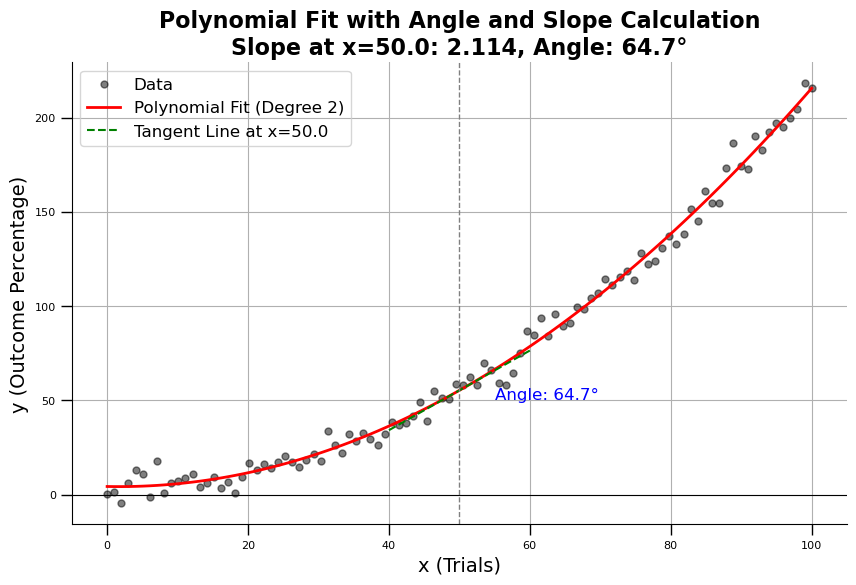

In [311]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Create fake data for demonstration
x = np.linspace(0, 100, 100)
y = 2 + 0.1 * x + 0.02 * x**2 + np.random.normal(scale=5, size=x.shape)

# Fit a polynomial regression model (degree 2)
poly = PolynomialFeatures(degree=2)
x_poly = poly.fit_transform(x.reshape(-1, 1))
model = LinearRegression().fit(x_poly, y)

# Calculate the slope (derivative) at the midpoint
x_mid = np.median(x)
x_mid_poly = poly.transform(np.array([[x_mid]]))
slope = model.coef_[1] + 2 * model.coef_[2] * x_mid

# Calculate the angle (in radians and degrees)
angle_radians = np.arctan(slope)
angle_degrees = np.degrees(angle_radians)

# Predicted y values for the plot
y_pred = model.predict(x_poly)

# Create a plot showing the line, angle, and slope
plt.figure(figsize=(10, 6))
plt.plot(x, y, 'o', label='Data', markersize=5, alpha=0.5)
plt.plot(x, y_pred, 'r-', label='Polynomial Fit (Degree 2)', linewidth=2)

# Plot the tangent line at the midpoint to show the slope
x_tangent = np.array([x_mid - 10, x_mid + 10])
y_tangent = slope * (x_tangent - x_mid) + model.predict(poly.transform(np.array([[x_mid]])))[0]
plt.plot(x_tangent, y_tangent, 'g--', label=f'Tangent Line at x={x_mid:.1f}')

# Plot the angle
plt.text(x_mid + 5, model.predict(poly.transform(np.array([[x_mid]])))[0] - 5,
         f'Angle: {angle_degrees:.1f}°', fontsize=12, color='blue')

# Labels and title
plt.axhline(0, color='black', linewidth=0.8)
plt.axvline(x_mid, color='gray', linestyle='--', linewidth=1)
plt.xlabel('x (Trials)', fontsize=14)
plt.ylabel('y (Outcome Percentage)', fontsize=14)
plt.title(f'Polynomial Fit with Angle and Slope Calculation\nSlope at x={x_mid:.1f}: {slope:.3f}, Angle: {angle_degrees:.1f}°', fontsize=16)
plt.legend()
plt.grid(True)

# Display the plot
plt.show()


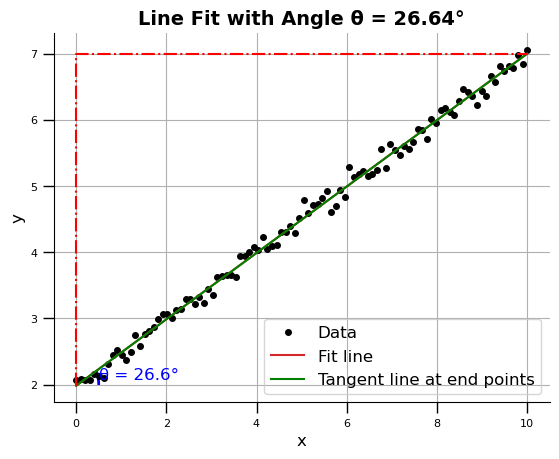

In [314]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Arc

# Generate some data
x = np.linspace(0, 10, 100)
y = 2 + 0.5 * x + np.random.normal(scale=0.1, size=x.shape)

# Fit a linear model
model = np.polyfit(x, y, 1)
predict = np.poly1d(model)

# Calculate angle
slope = model[0]
angle_radians = np.arctan(slope)
angle_degrees = np.degrees(angle_radians)

# Points for tangent line calculation
x_min, x_max = x.min(), x.max()
y_tangent_min = predict(x_min)
y_tangent_max = predict(x_max)

# Setup figure
fig, ax = plt.subplots()
ax.plot(x, y, 'o', label='Data')
ax.plot(x, predict(x), '-', label='Fit line')
ax.plot([x_min, x_max], [y_tangent_min, y_tangent_max], 'g-', label='Tangent line at end points')

# Draw triangle for angle visualization
triangle_x = [x_min, x_min, x_max]
triangle_y = [y_tangent_min, y_tangent_max, y_tangent_max]
ax.plot(triangle_x, triangle_y, 'r-.')

# Add arc to the plot to visualize the angle θ
arc_span = 1  # Span of the arc for visual clarity
arc = Arc([x_min, y_tangent_min], arc_span, arc_span, angle=0, theta1=0, theta2=angle_degrees, color='blue', lw=2)
ax.add_patch(arc)
ax.text(x_min + 0.5, y_tangent_min + 0.1, f'θ = {angle_degrees:.1f}°', color='blue')

# Labels and title
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
plt.grid(True)
plt.title(f'Line Fit with Angle θ = {angle_degrees:.2f}°')
plt.show()


# Plots d'

In [50]:
from scipy.stats import norm


In [88]:

folder_path = os.path.join('/datajoint-data/data/aeltona/', 'Learning Curves')
file_path = os.path.join(folder_path, f'trials_df.csv')
trials_df = pd.read_csv(file_path)# Convert 'Date' column to datetime
trials_df['Date'] = trials_df['Scan'].apply(lambda x: decode_base36_timestamp(x.replace('scan', '')))
trials_df = trials_df.sort_values(by='Date', ascending=False)
trials_df.shape

(7748, 8)

In [89]:
grouped = trials_df.groupby(['Mouse', 'Task', 'Date'])

In [114]:
def get_keys_by_value(d, target_value):
    """
    Yield keys from a dictionary that have the given value.

    Parameters:
    d (dict): The dictionary to search.
    target_value: The value to search for.

    Yields:
    key: Keys associated with the target_value.
    """
    for key, value in d.items():
        if value == target_value:
            yield key

def calculate_d_prime(hits, misses, false_alarms, correct_rejections):
    from scipy.stats import norm
    
    # Adjust ratios using the Hautus correction
    adjusted_hits = (hits + 0.5) / (hits + misses + 1)
    adjusted_fa = (false_alarms + 0.5) / (false_alarms + correct_rejections + 1)
    
    # Calculate z-scores
    z_hit = norm.ppf(adjusted_hits)
    z_fa = norm.ppf(adjusted_fa)
    
    # Calculate d-prime
    d_prime = z_hit - z_fa
    return d_prime


In [93]:
num_outcomes = [-1, 0, 1, 2]
for group_name, group_data in grouped:
    # print(f"Group: {group_name}")
    mouse,task, date = group_name
    print(mouse, task, date)
    df_outcomes = group_data.outcome.value_counts()
    for num in num_outcomes:
        if num in df_outcomes:
            if task not in passive_tasks:
                print(f'{percentage_map[num]}: {df_outcomes[num]}')
            else:
                # print('Skipping passive task')
                continue
                # outcome_key = list(get_keys_by_value(acronyms, percentage_map[num]))
                # print(f'{outcome_key[-1]}: {df_outcomes[num]}')
        # print()
    

ROS-1783 ActiveVisConditioningB 2024-06-10 17:15:06
FA: 12
Hit: 32
CR: 18
ROS-1783 ActiveVisConditioningB 2024-06-11 17:39:03
FA: 11
Hit: 36
CR: 21
ROS-1783 Habituation 2024-05-31 16:21:40
FA: 29
Hit: 22
CR: 61
ROS-1783 PassVisConditioningB 2024-06-08 19:52:54
ROS-1783 PassVisConditioningB 2024-06-09 19:29:47
ROS-1792 ActiveVisConditioningB 2024-06-14 12:21:31
Miss: 11
FA: 3
Hit: 29
CR: 34
ROS-1792 AudProbeB 2024-06-15 19:29:22
Miss: 19
CR: 16
ROS-1792 Habituation 2024-06-03 17:41:50
Miss: 3
FA: 14
Hit: 14
CR: 49
ROS-1792 Habituation 2024-06-04 17:30:57
Miss: 2
FA: 7
Hit: 17
CR: 78
ROS-1792 PassVisConditioningB 2024-06-10 17:32:26
ROS-1792 PassVisConditioningB 2024-06-10 18:33:33
ROS-1792 PassVisConditioningB 2024-06-11 16:30:46
ROS-1792 PassVisConditioningB 2024-06-12 14:29:54
ROS-1792 PassVisConditioningB 2024-06-13 16:38:19
ROS-1839 ActiveAudConditioningA 2024-08-26 22:20:31
Miss: 100
FA: 9
Hit: 4
CR: 92
ROS-1839 ActiveAudConditioningA 2024-08-27 21:05:37
Miss: 34
Hit: 1
CR: 32
ROS-

In [116]:
# Initialize an empty list to store rows for the new DataFrame
dprime_rows = []

# Iterate through the grouped data
for group_name, group_data in grouped:
    mouse, task, date = group_name
    df_outcomes = group_data.outcome.value_counts()
    
    # Initialize a dictionary for the current row
    row = {
        "Mouse": mouse,
        "Task": task,
        "Date": date
    }
    
    # Populate outcome percentages
    for num in num_outcomes:
        row[percentage_map[num]] = df_outcomes.get(num, 0)
    
    # Skip passive tasks for d-prime calculation
    if task not in passive_tasks:
        hits = row['Hit']
        misses = row['Miss']
        false_alarms = row['FA']
        correct_rejections = row['CR']
        # print(mouse,task,date)
        # Calculate d-prime and add to the row
        row["dprime"] = calculate_d_prime(hits, misses, false_alarms, correct_rejections)
        dprime_rows.append(row)
    else:
        # row["dprime"] = None  # No d-prime for passive tasks
        continue
    # Append the row to the list
    

# Create a DataFrame from the list of dictionaries
dprime_df = pd.DataFrame(dprime_rows)

In [ ]:
# dprime_df.to_csv('/datajoint-data/data/aeltona/Learning Curves/dprime_df.csv', index=False)

In [123]:
# Ensure Date is in datetime format
dprime_df["Date"] = pd.to_datetime(dprime_df["Date"])

# Sort by Mouse, Task, and Date
dprime_df = dprime_df.sort_values(by=["Mouse", "Task", "Date"])

# Create a new column for Session
dprime_df["Session"] = dprime_df.groupby(["Mouse", "Task"]).cumcount() + 1

In [128]:
dprime_df

Mouse                    Task                Date  Miss  FA  Hit   CR  \
0   ROS-1783  ActiveVisConditioningB 2024-06-10 17:15:06     0  12   32   18   
1   ROS-1783  ActiveVisConditioningB 2024-06-11 17:39:03     0  11   36   21   
2   ROS-1783             Habituation 2024-05-31 16:21:40     0  29   22   61   
3   ROS-1792  ActiveVisConditioningB 2024-06-14 12:21:31    11   3   29   34   
4   ROS-1792               AudProbeB 2024-06-15 19:29:22    19   0    0   16   
5   ROS-1792             Habituation 2024-06-03 17:41:50     3  14   14   49   
6   ROS-1792             Habituation 2024-06-04 17:30:57     2   7   17   78   
7   ROS-1839  ActiveAudConditioningA 2024-08-26 22:20:31   100   9    4   92   
8   ROS-1839  ActiveAudConditioningA 2024-08-27 21:05:37    34   0    1   32   
9   ROS-1839  ActiveAudConditioningA 2024-08-28 21:48:30    79   4    1   68   
10  ROS-1839  ActiveAudConditioningA 2024-08-31 22:34:38    42   3    1   41   
11  ROS-1839  ActiveAudConditioningB 2024-08-22 16:44:06     0  10   48   33   
12  ROS-1839  ActiveAudConditioningB 2024-08-23 21:22:41     0  20   78   62   
13  ROS-1839  ActiveVisConditioningB 2024-07-27 20:54:37    36  32   57   58   
14  ROS-1839  ActiveVisConditioningB 2024-07-28 21:27:50    41  11   47   79   
15  ROS-1839  ActiveVisConditioningB 2024-08-17 21:03:28     3  28   54   24   
16  ROS-1839  ActiveVisConditioningB 2024-08-19 12:00:58     0  85  102   10   
17  ROS-1839  ActiveVisConditioningB 2024-08-20 22:05:42     0  25  108   94   
18  ROS-1842  ActiveAudConditioningA 2024-08-21 20:17:28    46  11    4   43   
19  ROS-1842  ActiveAudConditioningA 2024-08-22 12:23:58    26   1    1   14   
20  ROS-1842  ActiveAudConditioningA 2024-08-23 17:29:09    81  29   21   70   
21  ROS-1842  ActiveAudConditioningA 2024-08-26 20:07:26    96  13   10   92   
22  ROS-1842  ActiveAudConditioningA 2024-08-27 22:30:08    33   1    4   31   
23  ROS-1842  ActiveAudConditioningA 2024-08-28 20:59:03    47   8    6   48   
24  ROS-1842  ActiveAudConditioningB 2024-08-20 19:59:26     0   7   77   76   
25  ROS-1842  ActiveVisConditioningB 2024-07-27 23:09:10     5  52  111   73   
26  ROS-1842  ActiveVisConditioningB 2024-07-28 22:21:55     0  14  119  104   
27  ROS-1842  ActiveVisConditioningB 2024-08-17 19:56:43     0  18   93   78   
28  ROS-1844  ActiveAudConditioningA 2024-08-21 18:50:18     0   8   38   29   
29  ROS-1844  ActiveAudConditioningA 2024-08-22 17:40:43     0   4   54   43   
30  ROS-1844  ActiveAudConditioningB 2024-08-23 18:47:07    65  27    0   14   
31  ROS-1844  ActiveAudConditioningB 2024-08-26 21:10:00   103   1    2  106   
32  ROS-1844  ActiveAudConditioningB 2024-08-27 21:52:37    72   1    1   65   
33  ROS-1844  ActiveAudConditioningB 2024-08-28 20:19:01    53   7    2   43   
34  ROS-1844  ActiveVisConditioningB 2024-07-26 17:37:14     2  20   35   15   
35  ROS-1844  ActiveVisConditioningB 2024-07-27 22:11:11    30  26   55   59   
36  ROS-1844  ActiveVisConditioningB 2024-07-28 20:27:59     0  36   79   35   
37  ROS-1844  ActiveVisConditioningB 2024-08-17 22:06:45     0  13   25    2   
38  ROS-1844  ActiveVisConditioningB 2024-08-19 11:02:13     0  49   68    9   
39  ROS-1844  ActiveVisConditioningB 2024-08-20 21:05:44     0   8   96   93   

      dprime  Session  
0   2.411113        1  
1   2.600542        2  
2   2.475140        1  
3   1.909295        1  
4  -0.070454        1  
5   1.611849        1  
6   2.508491        2  
7  -0.396771        1  
8   0.434442        2  
9  -0.544236        3  
10 -0.403624        4  
11  3.029454        1  
12  3.177242        2  
13  0.649864        1  
14  1.228296        2  
15  1.457154        3  
16  1.356175        4  
17  3.403266        5  
18 -0.542123        1  
19 -0.293158        2  
20 -0.271972        3  
21 -0.153309        4  
22  0.507705        5  
23 -0.132934        6  
24  3.833883        1  
25  1.885006        1  
26  3.804052        2  
27  3.429601        3  
28  2.991415        1  
29  3.

In [ ]:
d

In [121]:
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
task_order = ['Habituation','PassVisConditioningB','ActiveVisConditioningB','PassAudConditioningB','ActiveAudConditioningB','PassAudConditioningA','ActiveAudConditioningA', 'AudProbeB']


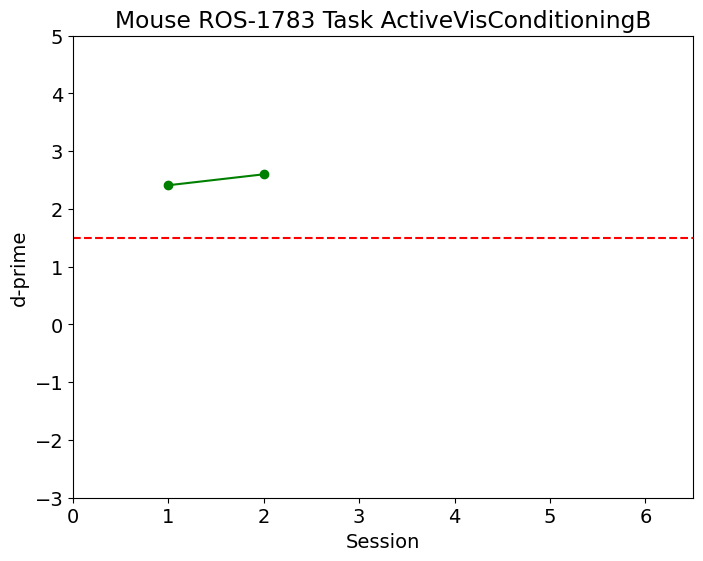

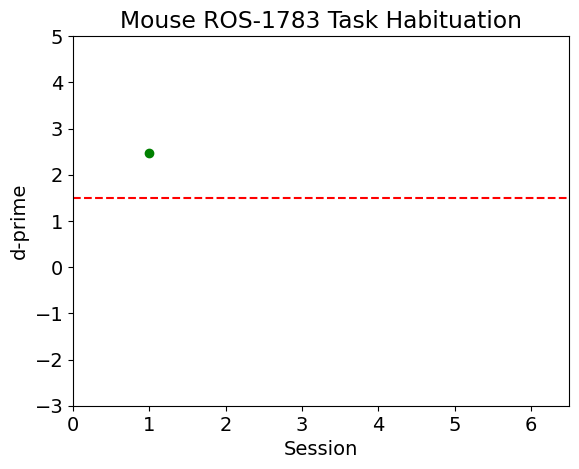

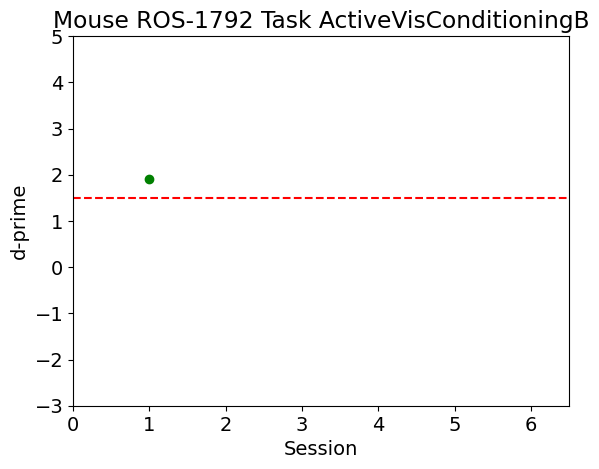

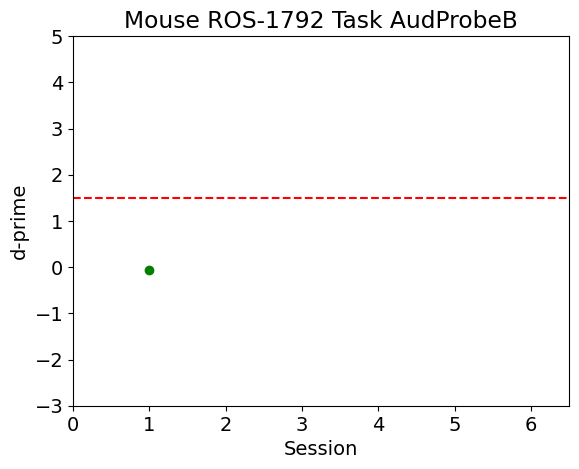

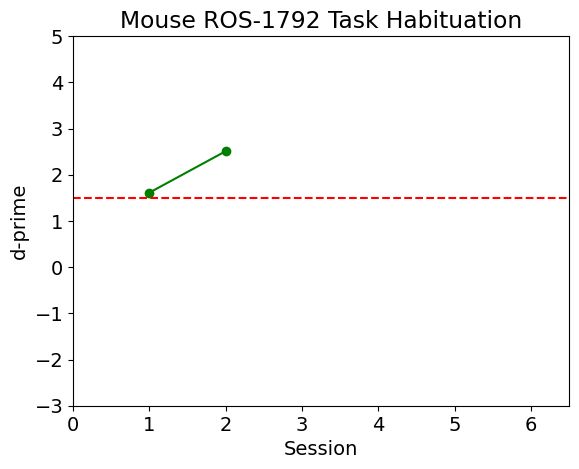

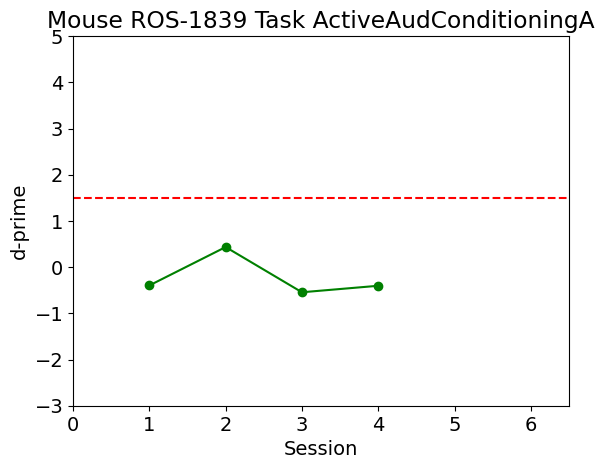

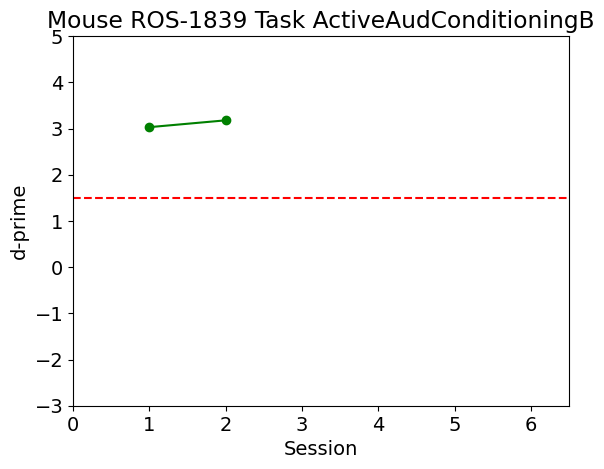

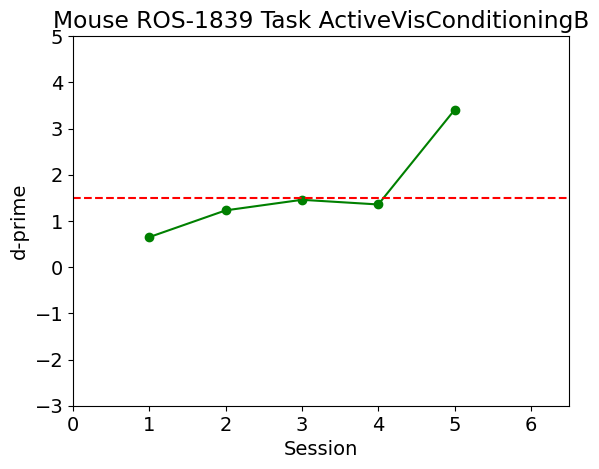

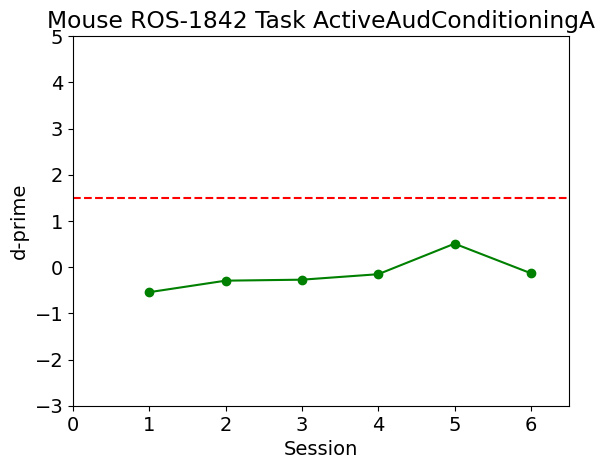

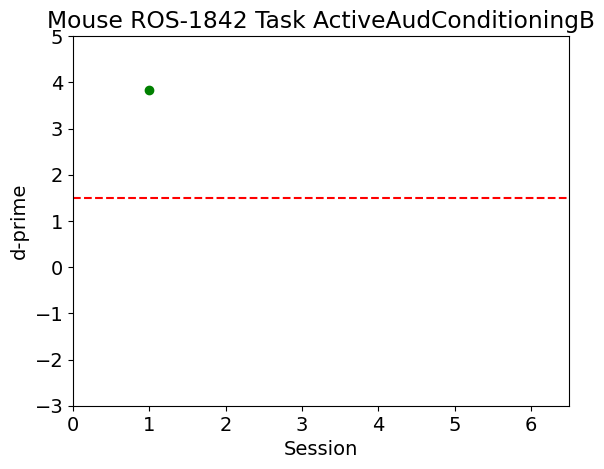

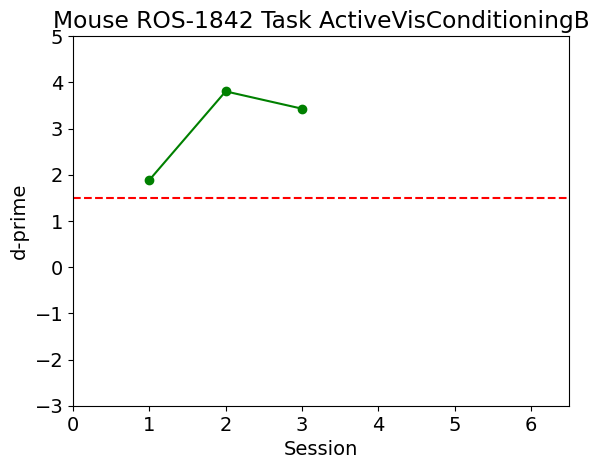

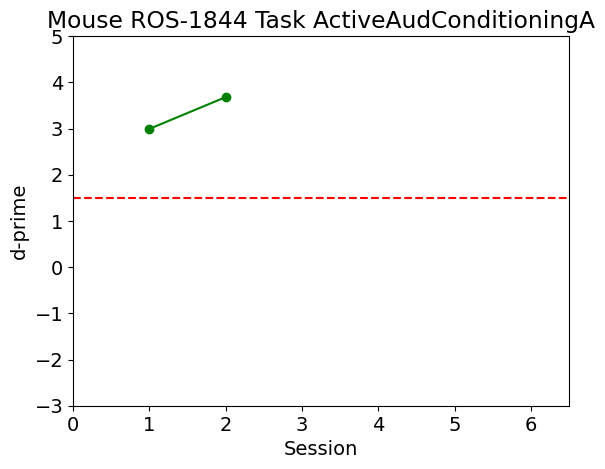

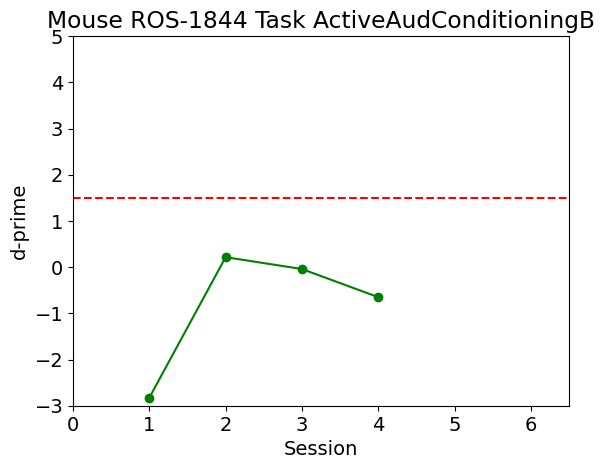

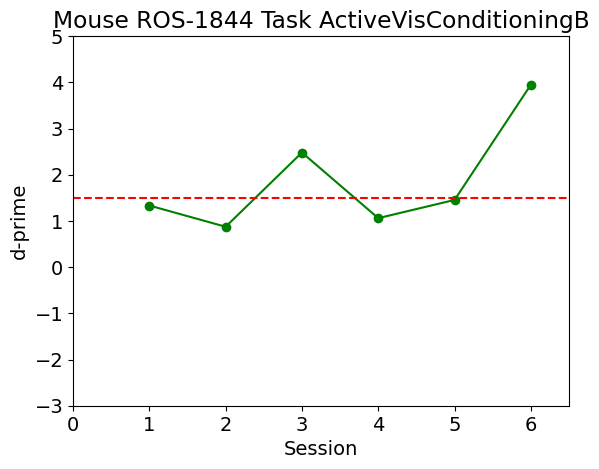

In [135]:
# Plot
plt.figure(figsize=(8, 6))
for (mouse, task), group in dprime_df.groupby(["Mouse", "Task"]):
    plt.plot(group["Session"], group["dprime"], label=f"{mouse} - {task}", marker='o', color='green')

# Add threshold line
    plt.axhline(y=1.5, color='red', linestyle='--', label="Learning Threshold")
    plt.xlim(0,6.5)
    plt.ylim(-3, 5)
    # Add labels and legend
    plt.xlabel("Session")
    plt.ylabel("d-prime")
    plt.title(f"Mouse {mouse} Task {task}")
    # plt.legend(''False'')
    plt.grid(False)
    plt.show()

# Checking bonsai logging files

In [76]:
# csv_files = glob(pjoin(localdisk,'*.h5'))[0]
stimulus_log_path = glob(pjoin(localdisk,'*stimulus_log*'))[0]
events_log_path = glob(pjoin(localdisk,'*events_log*'))[0]

In [75]:
# df.HIFI.plot()

In [36]:
threshold = df.HIFI.max()/2
binary_signal = (df.HIFI > threshold).astype(int)


In [53]:
(binary_signal.diff()>0).sum()

109

In [ ]:
time_vector = np.arange(binary_signal.shape[0]) / sampling_rate_hz
# print(time_vector.shape, binary_signal.shape)


(48055734,) (48055734,)


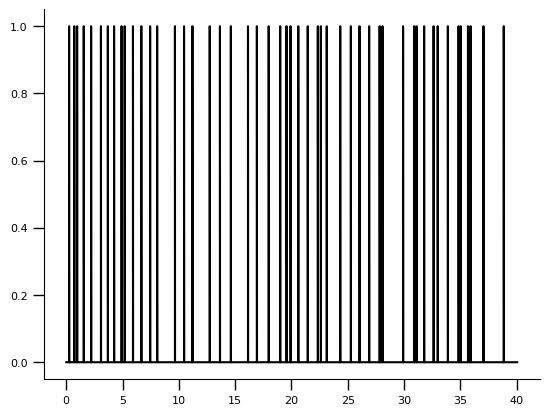

In [74]:
downsample_factor = 2
plt.plot(time_vector[::downsample_factor]/60, (binary_signal.diff()>0)[::downsample_factor]);

In [81]:
stim_log = pd.read_csv(stimulus_log_path)
events_log = pd.read_csv(events_log_path)
stim_log.shape

(109, 3)